# NeuralCompression Metrics Example

## Introduction

Welcome! This notebook will walkthrough using the `neuralcompression.metrics` and `torchmetrics` packages to evaluate models using rate distortion curves. 

First, if you haven't yet installed `neuralcompression`, do so below with: 

In [12]:
!git clone https://github.com/facebookresearch/NeuralCompression/

Cloning into 'NeuralCompression'...
remote: Enumerating objects: 1193, done.
remote: Counting objects: 100% (631/631), done.
remote: Compressing objects: 100% (383/383), done.
remote: Total 1193 (delta 430), reused 270 (delta 248), pack-reused 562
Receiving objects: 100% (1193/1193), 1.82 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (717/717), done.


In [1]:
!pip install git+https://github.com/facebookresearch/NeuralCompression/

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/NeuralCompression/ to /tmp/pip-req-build-bno1chdm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/NeuralCompression/ /tmp/pip-req-build-bno1chdm
  Resolved https://github.com/facebookresearch/NeuralCompression/ to commit af8021bf87b6729c78386dd23f3bb05b5334a332
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 164.8 kB/s eta 0:00:00 kB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
  Using cached jaxlib-0.3.2-cp38-none-manylinux2010_x86_64.whl (68.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached compressai-1.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (293 kB)
     ━━━━━━━━━━━━━━━━━━━━━

  Created wheel for jax: filename=jax-0.3.4-py3-none-any.whl size=1070939 sha256=2460cbcb59580a4d2766359be72e734b3a19ea4990253a35f23e4324c111556d
  Stored in directory: /home/mashmallow/.cache/pip/wheels/e1/9d/df/ed81293e72b30fb812b9c19a088cdfd9b4dd516ccc7c8397d0
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188715 sha256=703745b7da0ca8234c9798e37e636e9d877bc0f5fdd28abd5ae9d12060945ff4
  Stored in directory: /home/mashmallow/.cache/pip/wheels/84/62/e5/0b41f2deb978f449ba3efb4bb24efd6962e4b6abb1fae544ee
Successfully built neuralcompression jax pytorchvideo


In [2]:
!pip install -U importlib

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for importlib: filename=importlib-1.0.4-py3-none-any.whl size=5874 sha256=dd632d57e1bb8415930739820530fb0929bda2f2427d2310a436b59ebb7d4631
  Stored in directory: /home/mashmallow/.cache/pip/wheels/bb/1e/4d/b9e2665ab36264acf947eab5715b2e1ab4fd1649adcb96785d
Successfully built importlib


In [29]:
from collections import defaultdict
import io

import torch
from torch.utils.data import DataLoader

from compressai import zoo

import torchmetrics as tm
import torchmetrics.functional as tmF

import neuralcompression as nc
import neuralcompression.functional as ncF
import neuralcompression.metrics as ncm

import torchvision.transforms as tfms

from tqdm import tqdm

import math
from PIL import Image

import matplotlib.pyplot as plt

## Finding And Using Metrics

The metrics implemented in `neuralcompression.metrics` aim to complement/extend those aready in `torchmetrics`. `torchmetrics` features high-quality implementations of MSE, PSNR, FID, KID, and more (check the [package documentation](https://torchmetrics.readthedocs.io/en/latest/references/modules.html) for a complete list), and are therefore not reimplemented inside of `neuralcompression`. 

Most of the metrics supported in `torchmetrics` have both functional and `nn.Module`-based APIs. Module metrics add additional functionality like accumulation across batches and first-class [compatibility](https://torchmetrics.readthedocs.io/en/latest/pages/lightning.html) with PyTorch Lightning.

In [60]:
image_shape = (1,3,256,256)

image_a = torch.randn(image_shape)
image_b = torch.randn(image_shape)

In [61]:
psnr_metric = tm.PSNR()
psnr_module = psnr_metric(image_a, image_b)
psnr_functional = tmF.psnr(image_a, image_b)

psnr_module, psnr_functional

(tensor(16.1933), tensor(16.1933))

Metrics that are missing from `torchmetrics` that are otherwise important to compression, such as MS-SSIM and LPIPS, can be found in `neuralcompression`. Similar to `torchmetrics`, each metric has a functional API that can be imported from `neuralcompression.functional`, and a Module API found in `neuralcompression.metrics`.

In [62]:
ms_ssim_metric = ncm.MultiscaleStructuralSimilarity()

ms_ssim_module = ms_ssim_metric(image_a, image_b)
ms_ssim_functional = ncF.multiscale_structural_similarity(image_a, image_b)

ms_ssim_module, ms_ssim_functional

(tensor(0.0063), tensor(0.0063))

Module-based metrics in `neuralcompression` are instances of `torchmetrics.Metric`, so they are fully compatible with other `torchmetrics` features, like metric collections.

In [63]:
# Using metrics from both torchmetrics and neuralcompression
collection = tm.MetricCollection(
    psnr_metric,
    ms_ssim_metric
)

collection(image_a, image_b)

{'PSNR': tensor(16.1933), 'MultiscaleStructuralSimilarity': tensor(0.0063)}

## Calculating Rate-Distortion Curves

We'll now go through an example of calculating rate-distortion curves for the [scale hyperprior model](https://arxiv.org/abs/1802.01436) on the [Kodak dataset](http://www.cs.albany.edu/~xypan/research/snr/Kodak.html), comparing it to the non-ML image codec JPEG.

In [129]:
def make_jpeg_rd_curve(dataloader, metrics: tm.MetricCollection):
        
    rd_curve = []
    to_PIL = tfms.ToPILImage()
    to_tensor = tfms.ToTensor()
    
    for quality in tqdm(range(0, 91, 10)):
        
        bpp_sum = 0.0
        metrics_sum = defaultdict(lambda: 0.0)
        
        for img in dataloader:
            pil_image = to_PIL(img.squeeze(0))
            buffer = io.BytesIO()
            pil_image.save(buffer, format="JPEG", quality=quality)
            
            bits = len(buffer.getvalue()) * 8
            bpp = bits / (img.shape[2] * img.shape[3])
            
            bpp_sum += bpp
            
            reconstruction = to_tensor(Image.open(buffer, formats=["JPEG"])).unsqueeze(0)
            
            distortions = metrics(img, reconstruction)
            for k,v in distortions.items():
                metrics_sum[k] += v
        
        average_metrics = {k: v / len(dataloader) for k,v in metrics_sum.items()}
        average_bpp = bpp_sum / len(dataloader)
        
        rd_curve.append((average_bpp, average_metrics))
    
    return rd_curve

def make_scale_hyperprior_rd_curve(dataloader, metrics: tm.MetricCollection, data):
    rd_curve = []
    to_tensor = tfms.ToTensor()
            
    name, model_type = data   
    max_ = 9
    if name in ['Cheng-2020 anchor', 'Cheng-2020 attn']:
        max_ = 7
    for quality in tqdm(range(1, max_)): #пробуем разные ранги
        
        bpp_sum = 0.0
        metrics_sum = defaultdict(lambda: 0.0)
        
        #model = zoo.cheng2020_attn(quality=quality, pretrained=True)
        model = model_type(quality=quality, pretrained=True)
        model.eval()
        model.update()
        with torch.no_grad():
            for img in dataloader:         
                compressed = model.compress(img)
                bits = 0.0
                for string_list in compressed["strings"]: # strings for image + hyper latent
                    for string in string_list: # iterating over batch
                        bits += len(string) * 8

                bpp = bits / (img.shape[0] * img.shape[2] * img.shape[3])

                bpp_sum += bpp

                reconstruction = model.decompress(**compressed)["x_hat"]
                
                distortions = metrics(img, reconstruction) # тем же способом считаем метрики
                for k,v in distortions.items():
                    metrics_sum[k] += v

            average_metrics = {k: v / len(dataloader) for k,v in metrics_sum.items()}
            average_bpp = bpp_sum / len(dataloader)
            rd_curve.append((average_bpp, average_metrics))
        
        del model
    
    return rd_curve

In [130]:
# Pass download=True if dataset doesn't exist already

import sys
sys.path.append('./neuralcompression/data/')

from _kodak import Kodak

ds = Kodak("kodak", download=True, check_hash=False, transform = tfms.ToTensor())
dl = DataLoader(ds, batch_size = 1)
metrics = tm.MetricCollection(
    tm.PSNR(), 
    tm.MeanSquaredError(), 
    ncm.MultiscaleStructuralSimilarity()
)

RuntimeError: Dataset directory already exists - to proceed with dataset download anyways pass force_download=True

In [131]:
jpeg_curve = make_jpeg_rd_curve(dl, metrics )

100%|███████████████████████████████████████████| 10/10 [01:43<00:00, 10.38s/it]


In [132]:
models = [
    ('BMSHJ-2018 Factorized', zoo.bmshj2018_factorized), 
    ('BMSHJ-2018 Hyperprior', zoo.bmshj2018_hyperprior), 
    ('MBT-2018 mean', zoo.mbt2018_mean), 
    ('MBT-2018', zoo.mbt2018), 
    ('Cheng-2020 anchor', zoo.cheng2020_anchor),
    ('Cheng-2020 attn', zoo.cheng2020_attn)
]

curves = []

for data in models:
    shp_curve = make_scale_hyperprior_rd_curve(dl, metrics, data)
    curves.append(shp_curve)
    

 12%|█████▋                                       | 1/8 [00:31<03:41, 31.63s/it]Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-2-87279a02.pth.tar" to /home/mashmallow/.cache/torch/hub/checkpoints/bmshj2018-factorized-prior-2-87279a02.pth.tar

  0%|                                               | 0.00/11.5M [00:00<?, ?B/s]
  0%|                                      | 8.00k/11.5M [00:00<06:12, 32.4kB/s]
  0%|▏                                      | 56.0k/11.5M [00:00<01:23, 145kB/s]
  1%|▎                                       | 104k/11.5M [00:00<01:04, 185kB/s]
  2%|▉                                       | 264k/11.5M [00:00<00:28, 415kB/s]
  4%|█▍                                      | 432k/11.5M [00:01<00:20, 561kB/s]
  5%|██                                      | 600k/11.5M [00:01<00:17, 651kB/s]
  7%|██▋                                     | 784k/11.5M [00:01<00:15, 732kB/s]
  8%|███                                     | 904k/11.5M [00:01<00:1

 60%|███████████████████████▎               | 6.90M/11.5M [00:19<00:18, 259kB/s]
 60%|███████████████████████▍               | 6.95M/11.5M [00:20<00:19, 252kB/s]
 61%|███████████████████████▋               | 6.99M/11.5M [00:20<00:19, 247kB/s]
 61%|███████████████████████▊               | 7.05M/11.5M [00:20<00:18, 255kB/s]
 62%|████████████████████████               | 7.09M/11.5M [00:20<00:18, 249kB/s]
 62%|████████████████████████▏              | 7.14M/11.5M [00:21<00:18, 245kB/s]
 62%|████████████████████████▎              | 7.20M/11.5M [00:21<00:20, 221kB/s]
 63%|████████████████████████▌              | 7.24M/11.5M [00:21<00:19, 225kB/s]
 63%|████████████████████████▋              | 7.30M/11.5M [00:21<00:18, 239kB/s]
 64%|████████████████████████▊              | 7.34M/11.5M [00:22<00:26, 166kB/s]
 64%|█████████████████████████▏             | 7.43M/11.5M [00:22<00:19, 225kB/s]
 65%|█████████████████████████▏             | 7.46M/11.5M [00:22<00:20, 209kB/s]
 65%|███████████████████████

 91%|███████████████████████████████████▎   | 10.4M/11.5M [00:41<00:05, 219kB/s]
 91%|███████████████████████████████████▌   | 10.5M/11.5M [00:41<00:04, 243kB/s]
 91%|███████████████████████████████████▋   | 10.5M/11.5M [00:41<00:04, 248kB/s]
 92%|███████████████████████████████████▊   | 10.6M/11.5M [00:41<00:03, 259kB/s]
 92%|███████████████████████████████████▉   | 10.6M/11.5M [00:41<00:03, 258kB/s]
 93%|████████████████████████████████████▏  | 10.7M/11.5M [00:42<00:03, 276kB/s]
 93%|████████████████████████████████████▎  | 10.8M/11.5M [00:42<00:02, 292kB/s]
 94%|████████████████████████████████████▌  | 10.8M/11.5M [00:42<00:02, 306kB/s]
 94%|████████████████████████████████████▊  | 10.9M/11.5M [00:42<00:02, 335kB/s]
 95%|█████████████████████████████████████  | 10.9M/11.5M [00:42<00:01, 341kB/s]
 96%|█████████████████████████████████████▎ | 11.0M/11.5M [00:43<00:01, 275kB/s]
 97%|█████████████████████████████████████▋ | 11.1M/11.5M [00:43<00:01, 371kB/s]
 97%|███████████████████████

 69%|██████████████████████████▊            | 7.95M/11.6M [00:17<00:09, 408kB/s]
 70%|███████████████████████████▏           | 8.04M/11.6M [00:17<00:09, 403kB/s]
 70%|███████████████████████████▍           | 8.12M/11.6M [00:18<00:08, 411kB/s]
 71%|███████████████████████████▋           | 8.22M/11.6M [00:18<00:08, 428kB/s]
 72%|███████████████████████████▉           | 8.27M/11.6M [00:18<00:09, 371kB/s]
 72%|████████████████████████████▏          | 8.35M/11.6M [00:18<00:08, 390kB/s]
 73%|████████████████████████████▍          | 8.42M/11.6M [00:19<00:08, 376kB/s]
 73%|████████████████████████████▋          | 8.48M/11.6M [00:19<00:08, 360kB/s]
 74%|████████████████████████████▉          | 8.55M/11.6M [00:19<00:08, 358kB/s]
 75%|█████████████████████████████▏         | 8.63M/11.6M [00:19<00:08, 368kB/s]
 75%|█████████████████████████████▍         | 8.72M/11.6M [00:19<00:07, 386kB/s]
 76%|█████████████████████████████▋         | 8.79M/11.6M [00:20<00:07, 389kB/s]
 77%|███████████████████████

 70%|██████████████████████████▌           | 8.12M/11.6M [00:05<00:02, 1.24MB/s]
 71%|███████████████████████████           | 8.26M/11.6M [00:05<00:03, 1.09MB/s]
 73%|███████████████████████████▋          | 8.46M/11.6M [00:05<00:03, 1.06MB/s]
 75%|████████████████████████████▎         | 8.65M/11.6M [00:05<00:02, 1.03MB/s]
 76%|█████████████████████████████         | 8.85M/11.6M [00:06<00:02, 1.03MB/s]
 78%|█████████████████████████████▋        | 9.07M/11.6M [00:06<00:02, 1.05MB/s]
 80%|██████████████████████████████▍       | 9.27M/11.6M [00:06<00:02, 1.04MB/s]
 82%|███████████████████████████████       | 9.49M/11.6M [00:06<00:02, 1.06MB/s]
 84%|███████████████████████████████▊      | 9.71M/11.6M [00:06<00:01, 1.06MB/s]
 85%|████████████████████████████████▍     | 9.90M/11.6M [00:07<00:01, 1.03MB/s]
 86%|█████████████████████████████████▋     | 10.0M/11.6M [00:07<00:01, 913kB/s]
 87%|██████████████████████████████████     | 10.1M/11.6M [00:07<00:01, 778kB/s]
 88%|███████████████████████

 40%|███████████████▍                       | 4.63M/11.7M [00:12<00:29, 254kB/s]
 40%|███████████████▋                       | 4.70M/11.7M [00:12<00:25, 289kB/s]
 41%|███████████████▉                       | 4.75M/11.7M [00:12<00:25, 286kB/s]
 41%|████████████████                       | 4.82M/11.7M [00:13<00:24, 288kB/s]
 42%|████████████████▎                      | 4.88M/11.7M [00:13<00:24, 296kB/s]
 42%|████████████████▌                      | 4.95M/11.7M [00:13<00:22, 313kB/s]
 43%|████████████████▋                      | 5.00M/11.7M [00:13<00:23, 299kB/s]
 43%|████████████████▉                      | 5.07M/11.7M [00:13<00:21, 326kB/s]
 44%|█████████████████▏                     | 5.13M/11.7M [00:14<00:22, 301kB/s]
 45%|█████████████████▍                     | 5.20M/11.7M [00:14<00:21, 317kB/s]
 45%|█████████████████▌                     | 5.27M/11.7M [00:14<00:27, 243kB/s]
 46%|█████████████████▊                     | 5.34M/11.7M [00:15<00:24, 272kB/s]
 46%|██████████████████     

  2%|▉                                       | 632k/27.3M [00:01<00:35, 780kB/s]
  3%|█▏                                      | 856k/27.3M [00:01<00:30, 919kB/s]
  3%|█▎                                      | 952k/27.3M [00:01<00:34, 792kB/s]
  4%|█▋                                    | 1.22M/27.3M [00:01<00:25, 1.07MB/s]
  5%|█▉                                    | 1.38M/27.3M [00:01<00:26, 1.05MB/s]
  6%|██▏                                   | 1.56M/27.3M [00:02<00:27, 1.00MB/s]
  6%|██▍                                    | 1.72M/27.3M [00:02<00:30, 889kB/s]
  7%|██▌                                    | 1.81M/27.3M [00:02<00:35, 761kB/s]
  7%|██▋                                    | 1.89M/27.3M [00:02<00:39, 676kB/s]
  7%|██▊                                    | 1.96M/27.3M [00:02<00:44, 598kB/s]
  8%|██▉                                    | 2.06M/27.3M [00:03<00:44, 590kB/s]
  8%|███                                    | 2.12M/27.3M [00:03<00:50, 522kB/s]
  8%|███                    

 25%|█████████▌                             | 6.73M/27.3M [00:21<00:52, 412kB/s]
 25%|█████████▋                             | 6.80M/27.3M [00:21<00:52, 412kB/s]
 25%|█████████▊                             | 6.88M/27.3M [00:21<00:50, 423kB/s]
 26%|█████████▉                             | 6.98M/27.3M [00:22<00:45, 467kB/s]
 26%|██████████                             | 7.06M/27.3M [00:22<00:46, 460kB/s]
 26%|██████████▏                            | 7.14M/27.3M [00:22<00:46, 457kB/s]
 27%|██████████▎                            | 7.24M/27.3M [00:22<00:42, 493kB/s]
 27%|██████████▍                            | 7.33M/27.3M [00:22<00:42, 493kB/s]
 27%|██████████▌                            | 7.43M/27.3M [00:22<00:40, 520kB/s]
 28%|██████████▋                            | 7.52M/27.3M [00:23<00:39, 526kB/s]
 28%|██████████▊                            | 7.61M/27.3M [00:23<00:40, 516kB/s]
 28%|██████████▉                            | 7.66M/27.3M [00:23<00:45, 455kB/s]
 28%|███████████            

 71%|██████████████████████████▊           | 19.3M/27.3M [00:40<00:02, 2.87MB/s]
 73%|███████████████████████████▋          | 19.9M/27.3M [00:41<00:02, 3.03MB/s]
 75%|████████████████████████████▌         | 20.5M/27.3M [00:41<00:02, 3.18MB/s]
 76%|████████████████████████████▉         | 20.8M/27.3M [00:41<00:02, 2.64MB/s]
 79%|██████████████████████████████        | 21.6M/27.3M [00:41<00:01, 3.37MB/s]
 81%|██████████████████████████████▋       | 22.1M/27.3M [00:41<00:01, 3.16MB/s]
 83%|███████████████████████████████▍      | 22.6M/27.3M [00:42<00:01, 3.07MB/s]
 85%|████████████████████████████████      | 23.1M/27.3M [00:42<00:01, 3.01MB/s]
 86%|████████████████████████████████▌     | 23.4M/27.3M [00:42<00:01, 2.60MB/s]
 87%|█████████████████████████████████▏    | 23.9M/27.3M [00:42<00:01, 2.69MB/s]
 88%|█████████████████████████████████▌    | 24.2M/27.3M [00:42<00:01, 2.69MB/s]
 89%|█████████████████████████████████▉    | 24.4M/27.3M [00:42<00:01, 2.30MB/s]
 91%|███████████████████████

 41%|███████████████▉                       | 11.3M/27.5M [00:15<00:25, 678kB/s]
 42%|████████████████▏                      | 11.4M/27.5M [00:15<00:23, 710kB/s]
 42%|████████████████▍                      | 11.6M/27.5M [00:15<00:22, 738kB/s]
 43%|████████████████▋                      | 11.8M/27.5M [00:16<00:21, 768kB/s]
 43%|████████████████▉                      | 11.9M/27.5M [00:16<00:20, 785kB/s]
 44%|█████████████████▏                     | 12.1M/27.5M [00:16<00:20, 807kB/s]
 45%|█████████████████▍                     | 12.3M/27.5M [00:16<00:19, 834kB/s]
 45%|█████████████████▋                     | 12.5M/27.5M [00:16<00:19, 833kB/s]
 46%|█████████████████▉                     | 12.6M/27.5M [00:17<00:18, 854kB/s]
 47%|██████████████████▏                    | 12.8M/27.5M [00:17<00:17, 878kB/s]
 47%|██████████████████▍                    | 13.0M/27.5M [00:17<00:17, 893kB/s]
 48%|██████████████████▋                    | 13.2M/27.5M [00:17<00:15, 945kB/s]
 48%|██████████████████▉    

  0%|                                      | 16.0k/27.9M [00:00<06:05, 79.9kB/s]
  0%|                                       | 48.0k/27.9M [00:00<03:52, 125kB/s]
  0%|▏                                      | 96.0k/27.9M [00:00<02:45, 176kB/s]
  1%|▎                                       | 184k/27.9M [00:00<01:44, 277kB/s]
  1%|▍                                       | 280k/27.9M [00:01<01:23, 347kB/s]
  1%|▌                                       | 384k/27.9M [00:01<01:11, 402kB/s]
  2%|▋                                       | 488k/27.9M [00:01<01:05, 438kB/s]
  2%|▊                                       | 552k/27.9M [00:01<01:10, 408kB/s]
  2%|▉                                       | 712k/27.9M [00:01<00:52, 547kB/s]
  3%|█                                       | 776k/27.9M [00:02<00:58, 488kB/s]
  3%|█▏                                      | 880k/27.9M [00:02<00:55, 508kB/s]
  3%|█▎                                      | 960k/27.9M [00:02<01:02, 452kB/s]
  4%|█▍                     

 60%|███████████████████████▍               | 16.8M/27.9M [00:19<00:15, 770kB/s]
 61%|███████████████████████▋               | 16.9M/27.9M [00:19<00:16, 710kB/s]
 61%|███████████████████████▊               | 17.0M/27.9M [00:20<00:15, 717kB/s]
 62%|████████████████████████               | 17.2M/27.9M [00:20<00:16, 688kB/s]
 62%|████████████████████████▏              | 17.3M/27.9M [00:20<00:17, 647kB/s]
 62%|████████████████████████▎              | 17.4M/27.9M [00:20<00:16, 651kB/s]
 63%|████████████████████████▌              | 17.6M/27.9M [00:21<00:20, 524kB/s]
 64%|████████████████████████▊              | 17.7M/27.9M [00:21<00:18, 568kB/s]
 64%|████████████████████████▉              | 17.8M/27.9M [00:21<00:17, 589kB/s]
 64%|█████████████████████████▏             | 18.0M/27.9M [00:21<00:19, 534kB/s]
 65%|█████████████████████████▎             | 18.1M/27.9M [00:22<00:19, 529kB/s]
 65%|█████████████████████████▌             | 18.2M/27.9M [00:22<00:17, 563kB/s]
 66%|███████████████████████

  9%|███▋                                   | 2.61M/27.6M [00:04<00:31, 827kB/s]
 10%|███▉                                   | 2.76M/27.6M [00:04<00:34, 747kB/s]
 11%|████▏                                  | 2.92M/27.6M [00:04<00:33, 769kB/s]
 11%|████▎                                  | 3.09M/27.6M [00:05<00:32, 796kB/s]
 12%|████▌                                  | 3.26M/27.6M [00:05<00:31, 804kB/s]
 12%|████▊                                  | 3.44M/27.6M [00:05<00:30, 832kB/s]
 13%|█████                                  | 3.62M/27.6M [00:05<00:28, 885kB/s]
 14%|█████▎                                 | 3.79M/27.6M [00:05<00:29, 847kB/s]
 14%|█████▌                                 | 3.97M/27.6M [00:06<00:28, 863kB/s]
 15%|█████▊                                 | 4.16M/27.6M [00:06<00:27, 884kB/s]
 16%|██████▏                                | 4.35M/27.6M [00:06<00:26, 914kB/s]
 16%|██████▍                                | 4.54M/27.6M [00:06<00:26, 922kB/s]
 17%|██████▌                

 82%|███████████████████████████████       | 22.6M/27.6M [00:24<00:02, 2.45MB/s]
 83%|███████████████████████████████▋      | 23.0M/27.6M [00:24<00:01, 2.53MB/s]
 85%|████████████████████████████████▎     | 23.5M/27.6M [00:24<00:01, 2.64MB/s]
 86%|████████████████████████████████▋     | 23.8M/27.6M [00:24<00:01, 2.10MB/s]
 88%|█████████████████████████████████▌    | 24.4M/27.6M [00:24<00:01, 2.93MB/s]
 90%|██████████████████████████████████    | 24.7M/27.6M [00:24<00:01, 2.85MB/s]
 91%|██████████████████████████████████▍   | 25.1M/27.6M [00:25<00:01, 2.61MB/s]
 92%|██████████████████████████████████▊   | 25.3M/27.6M [00:25<00:01, 2.36MB/s]
 93%|███████████████████████████████████▏  | 25.6M/27.6M [00:25<00:01, 2.10MB/s]
 94%|███████████████████████████████████▋  | 25.9M/27.6M [00:25<00:00, 2.31MB/s]
 95%|███████████████████████████████████▉  | 26.2M/27.6M [00:25<00:00, 2.28MB/s]
 96%|████████████████████████████████████▎ | 26.4M/27.6M [00:25<00:00, 2.06MB/s]
 97%|███████████████████████

 46%|█████████████████▊                     | 12.6M/27.6M [00:16<00:24, 644kB/s]
 46%|██████████████████                     | 12.8M/27.6M [00:16<00:23, 652kB/s]
 47%|██████████████████▏                    | 12.9M/27.6M [00:16<00:25, 610kB/s]
 47%|██████████████████▎                    | 13.0M/27.6M [00:16<00:24, 627kB/s]
 48%|██████████████████▌                    | 13.1M/27.6M [00:17<00:24, 633kB/s]
 48%|██████████████████▋                    | 13.3M/27.6M [00:17<00:23, 649kB/s]
 48%|██████████████████▉                    | 13.4M/27.6M [00:17<00:22, 667kB/s]
 49%|███████████████████                    | 13.5M/27.6M [00:17<00:21, 682kB/s]
 49%|███████████████████▎                   | 13.7M/27.6M [00:17<00:21, 694kB/s]
 50%|███████████████████▍                   | 13.8M/27.6M [00:18<00:20, 707kB/s]
 50%|███████████████████▋                   | 13.9M/27.6M [00:18<00:22, 650kB/s]
 51%|███████████████████▊                   | 14.1M/27.6M [00:18<00:21, 659kB/s]
 51%|████████████████████   

 95%|████████████████████████████████████▉  | 26.2M/27.6M [00:37<00:03, 492kB/s]
 95%|█████████████████████████████████████  | 26.3M/27.6M [00:37<00:02, 520kB/s]
 96%|█████████████████████████████████████▎ | 26.4M/27.6M [00:37<00:02, 518kB/s]
 96%|█████████████████████████████████████▍ | 26.5M/27.6M [00:38<00:02, 538kB/s]
 96%|█████████████████████████████████████▌ | 26.6M/27.6M [00:38<00:02, 531kB/s]
 97%|█████████████████████████████████████▋ | 26.7M/27.6M [00:38<00:01, 548kB/s]
 97%|█████████████████████████████████████▉ | 26.8M/27.6M [00:38<00:01, 548kB/s]
 98%|██████████████████████████████████████ | 27.0M/27.6M [00:38<00:01, 583kB/s]
 98%|██████████████████████████████████████▏| 27.1M/27.6M [00:39<00:00, 583kB/s]
 98%|██████████████████████████████████████▍| 27.2M/27.6M [00:39<00:00, 587kB/s]
 99%|██████████████████████████████████████▌| 27.3M/27.6M [00:39<00:00, 599kB/s]
 99%|██████████████████████████████████████▊| 27.5M/27.6M [00:39<00:00, 626kB/s]
100%|███████████████████████

 67%|██████████████████████████▏            | 18.6M/27.6M [00:16<00:10, 907kB/s]
 68%|██████████████████████████▌            | 18.8M/27.6M [00:16<00:09, 990kB/s]
 69%|██████████████████████████▊            | 19.0M/27.6M [00:17<00:09, 937kB/s]
 69%|██████████████████████████▉            | 19.1M/27.6M [00:17<00:09, 935kB/s]
 70%|███████████████████████████▏           | 19.3M/27.6M [00:17<00:09, 884kB/s]
 70%|███████████████████████████▍           | 19.5M/27.6M [00:17<00:09, 868kB/s]
 71%|███████████████████████████▋           | 19.6M/27.6M [00:17<00:09, 906kB/s]
 72%|███████████████████████████▉           | 19.8M/27.6M [00:18<00:08, 928kB/s]
 72%|████████████████████████████           | 19.9M/27.6M [00:18<00:10, 806kB/s]
 73%|████████████████████████████▍          | 20.1M/27.6M [00:18<00:08, 932kB/s]
 73%|████████████████████████████▌          | 20.2M/27.6M [00:18<00:08, 868kB/s]
 74%|████████████████████████████▊          | 20.4M/27.6M [00:18<00:09, 823kB/s]
 74%|███████████████████████

 10%|███▋                                   | 6.50M/67.8M [00:05<01:19, 807kB/s]
 10%|███▊                                   | 6.62M/67.8M [00:05<01:34, 678kB/s]
 10%|███▊                                   | 6.73M/67.8M [00:06<01:54, 558kB/s]
 10%|███▉                                   | 6.86M/67.8M [00:06<01:50, 576kB/s]
 10%|████                                   | 6.98M/67.8M [00:06<01:48, 591kB/s]
 10%|████                                   | 7.11M/67.8M [00:06<01:46, 600kB/s]
 11%|████                                   | 7.17M/67.8M [00:06<02:02, 517kB/s]
 11%|████▏                                  | 7.33M/67.8M [00:07<01:46, 596kB/s]
 11%|████▎                                  | 7.42M/67.8M [00:07<01:53, 559kB/s]
 11%|████▎                                  | 7.52M/67.8M [00:07<01:58, 533kB/s]
 11%|████▎                                  | 7.61M/67.8M [00:07<02:02, 515kB/s]
 11%|████▍                                  | 7.72M/67.8M [00:07<02:00, 524kB/s]
 12%|████▍                  

 32%|████████████▎                          | 21.4M/67.8M [00:26<00:57, 851kB/s]
 32%|████████████▍                          | 21.6M/67.8M [00:26<00:54, 893kB/s]
 32%|████████████▍                          | 21.7M/67.8M [00:26<01:02, 780kB/s]
 32%|████████████▌                          | 21.8M/67.8M [00:26<01:03, 754kB/s]
 32%|████████████▋                          | 22.0M/67.8M [00:27<00:59, 808kB/s]
 33%|████████████▊                          | 22.2M/67.8M [00:27<00:55, 868kB/s]
 33%|████████████▉                          | 22.4M/67.8M [00:27<00:53, 895kB/s]
 33%|████████████▉                          | 22.6M/67.8M [00:27<00:51, 922kB/s]
 34%|█████████████                          | 22.8M/67.8M [00:27<00:48, 976kB/s]
 34%|████████████▉                         | 23.0M/67.8M [00:28<00:46, 1.01MB/s]
 34%|█████████████                         | 23.3M/67.8M [00:28<00:44, 1.06MB/s]
 35%|█████████████▏                        | 23.5M/67.8M [00:28<00:42, 1.10MB/s]
 35%|█████████████▎         

 54%|█████████████████████▏                 | 36.8M/67.8M [00:46<00:49, 657kB/s]
 54%|█████████████████████▏                 | 36.9M/67.8M [00:47<00:55, 588kB/s]
 55%|█████████████████████▎                 | 37.0M/67.8M [00:47<00:53, 599kB/s]
 55%|█████████████████████▎                 | 37.2M/67.8M [00:47<00:51, 630kB/s]
 55%|█████████████████████▍                 | 37.3M/67.8M [00:47<00:49, 652kB/s]
 55%|█████████████████████▌                 | 37.5M/67.8M [00:47<00:46, 685kB/s]
 55%|█████████████████████▌                 | 37.6M/67.8M [00:48<00:44, 707kB/s]
 56%|█████████████████████▋                 | 37.7M/67.8M [00:48<00:43, 723kB/s]
 56%|█████████████████████▊                 | 37.9M/67.8M [00:48<00:46, 671kB/s]
 56%|█████████████████████▊                 | 38.0M/67.8M [00:48<00:44, 697kB/s]
 56%|█████████████████████▉                 | 38.2M/67.8M [00:48<00:42, 729kB/s]
 56%|██████████████████████                 | 38.3M/67.8M [00:49<00:49, 630kB/s]
 57%|██████████████████████ 

 71%|███████████████████████████▋           | 48.1M/67.8M [01:07<00:58, 354kB/s]
 71%|███████████████████████████▋           | 48.1M/67.8M [01:07<00:58, 352kB/s]
 71%|███████████████████████████▋           | 48.2M/67.8M [01:07<00:58, 355kB/s]
 71%|███████████████████████████▋           | 48.3M/67.8M [01:08<00:58, 352kB/s]
 71%|███████████████████████████▊           | 48.3M/67.8M [01:08<00:54, 373kB/s]
 71%|███████████████████████████▊           | 48.4M/67.8M [01:08<01:00, 338kB/s]
 71%|███████████████████████████▊           | 48.5M/67.8M [01:08<00:57, 352kB/s]
 72%|███████████████████████████▉           | 48.6M/67.8M [01:08<00:55, 365kB/s]
 72%|███████████████████████████▉           | 48.6M/67.8M [01:09<00:56, 359kB/s]
 72%|███████████████████████████▉           | 48.7M/67.8M [01:09<00:52, 379kB/s]
 72%|████████████████████████████           | 48.8M/67.8M [01:09<00:50, 393kB/s]
 72%|████████████████████████████           | 48.9M/67.8M [01:09<00:54, 364kB/s]
 72%|███████████████████████

 87%|█████████████████████████████████▉     | 59.0M/67.8M [01:28<00:11, 836kB/s]
 87%|██████████████████████████████████     | 59.2M/67.8M [01:28<00:10, 850kB/s]
 87%|██████████████████████████████████     | 59.3M/67.8M [01:28<00:10, 850kB/s]
 88%|██████████████████████████████████▏    | 59.5M/67.8M [01:28<00:09, 880kB/s]
 88%|██████████████████████████████████▎    | 59.7M/67.8M [01:29<00:09, 875kB/s]
 88%|██████████████████████████████████▍    | 59.9M/67.8M [01:29<00:09, 872kB/s]
 89%|██████████████████████████████████▌    | 60.0M/67.8M [01:29<00:10, 776kB/s]
 89%|██████████████████████████████████▌    | 60.2M/67.8M [01:29<00:09, 819kB/s]
 89%|██████████████████████████████████▋    | 60.4M/67.8M [01:30<00:09, 852kB/s]
 89%|██████████████████████████████████▊    | 60.6M/67.8M [01:30<00:09, 835kB/s]
 90%|██████████████████████████████████▉    | 60.8M/67.8M [01:30<00:08, 843kB/s]
 90%|███████████████████████████████████    | 60.9M/67.8M [01:30<00:08, 848kB/s]
 90%|███████████████████████

 17%|██████▌                               | 11.7M/67.9M [00:10<00:33, 1.74MB/s]
 17%|██████▋                               | 11.9M/67.9M [00:10<00:46, 1.27MB/s]
 18%|██████▊                               | 12.2M/67.9M [00:10<00:39, 1.47MB/s]
 18%|██████▉                               | 12.4M/67.9M [00:11<00:42, 1.37MB/s]
 19%|███████                               | 12.6M/67.9M [00:11<00:41, 1.41MB/s]
 19%|███████▏                              | 12.8M/67.9M [00:11<00:51, 1.11MB/s]
 19%|███████▎                              | 13.0M/67.9M [00:11<00:45, 1.27MB/s]
 19%|███████▍                              | 13.2M/67.9M [00:11<00:50, 1.14MB/s]
 20%|███████▍                              | 13.4M/67.9M [00:12<00:53, 1.07MB/s]
 20%|███████▌                              | 13.5M/67.9M [00:12<00:55, 1.02MB/s]
 20%|███████▊                               | 13.7M/67.9M [00:12<00:57, 996kB/s]
 20%|███████▊                              | 13.9M/67.9M [00:12<00:53, 1.06MB/s]
 21%|████████               

 38%|██████████████▌                       | 26.0M/67.9M [00:24<00:42, 1.04MB/s]
 39%|██████████████▋                       | 26.3M/67.9M [00:25<00:40, 1.08MB/s]
 39%|██████████████▊                       | 26.5M/67.9M [00:25<00:40, 1.06MB/s]
 39%|██████████████▉                       | 26.7M/67.9M [00:25<00:40, 1.06MB/s]
 40%|███████████████                       | 26.9M/67.9M [00:25<00:40, 1.07MB/s]
 40%|███████████████▏                      | 27.1M/67.9M [00:26<00:39, 1.08MB/s]
 40%|███████████████▎                      | 27.3M/67.9M [00:26<00:38, 1.10MB/s]
 41%|███████████████▍                      | 27.6M/67.9M [00:26<00:39, 1.07MB/s]
 41%|███████████████▉                       | 27.7M/67.9M [00:26<00:45, 917kB/s]
 41%|████████████████                       | 27.9M/67.9M [00:26<00:44, 948kB/s]
 41%|████████████████▏                      | 28.1M/67.9M [00:27<00:42, 993kB/s]
 42%|███████████████▊                      | 28.3M/67.9M [00:27<00:38, 1.07MB/s]
 42%|███████████████▉       

 96%|████████████████████████████████████▌ | 65.3M/67.9M [00:40<00:00, 3.85MB/s]
 97%|████████████████████████████████████▊ | 65.6M/67.9M [00:40<00:00, 3.56MB/s]
 97%|████████████████████████████████████▉ | 66.0M/67.9M [00:40<00:00, 3.38MB/s]
 98%|█████████████████████████████████████▎| 66.5M/67.9M [00:40<00:00, 3.82MB/s]
 99%|█████████████████████████████████████▍| 66.9M/67.9M [00:41<00:00, 3.52MB/s]
 99%|█████████████████████████████████████▋| 67.3M/67.9M [00:41<00:00, 3.37MB/s]
100%|██████████████████████████████████████| 67.9M/67.9M [00:41<00:00, 1.72MB/s]
 75%|█████████████████████████████████▊           | 6/8 [07:56<03:08, 94.39s/it]Downloading: "https://compressai.s3.amazonaws.com/models/v1/mbt2018-mean-7-d5d441d1.pth.tar" to /home/mashmallow/.cache/torch/hub/checkpoints/mbt2018-mean-7-d5d441d1.pth.tar

  0%|                                               | 0.00/67.9M [00:00<?, ?B/s]
  0%|                                      | 16.0k/67.9M [00:00<14:40, 80.8kB/s]
  0%|           

 50%|███████████████████                   | 34.0M/67.9M [00:16<00:27, 1.28MB/s]
 51%|███████████████████▏                  | 34.3M/67.9M [00:16<00:26, 1.31MB/s]
 51%|███████████████████▎                  | 34.5M/67.9M [00:16<00:28, 1.22MB/s]
 51%|███████████████████▍                  | 34.8M/67.9M [00:16<00:28, 1.22MB/s]
 52%|███████████████████▌                  | 35.0M/67.9M [00:16<00:30, 1.15MB/s]
 52%|████████████████████▏                  | 35.1M/67.9M [00:17<00:34, 996kB/s]
 52%|████████████████████▎                  | 35.3M/67.9M [00:17<00:34, 980kB/s]
 52%|████████████████████▍                  | 35.5M/67.9M [00:17<00:34, 990kB/s]
 53%|████████████████████▌                  | 35.7M/67.9M [00:17<00:33, 999kB/s]
 53%|████████████████████                  | 35.9M/67.9M [00:17<00:33, 1.00MB/s]
 53%|████████████████████▏                 | 36.1M/67.9M [00:18<00:32, 1.03MB/s]
 54%|████████████████████▎                 | 36.3M/67.9M [00:18<00:31, 1.05MB/s]
 54%|████████████████████▍  

 75%|█████████████████████████████▏         | 50.8M/67.9M [00:37<00:27, 642kB/s]
 75%|█████████████████████████████▎         | 51.0M/67.9M [00:37<00:26, 662kB/s]
 75%|█████████████████████████████▎         | 51.1M/67.9M [00:37<00:26, 675kB/s]
 76%|█████████████████████████████▍         | 51.2M/67.9M [00:37<00:25, 684kB/s]
 76%|█████████████████████████████▌         | 51.4M/67.9M [00:37<00:23, 731kB/s]
 76%|█████████████████████████████▋         | 51.6M/67.9M [00:38<00:22, 767kB/s]
 76%|█████████████████████████████▋         | 51.7M/67.9M [00:38<00:22, 769kB/s]
 76%|█████████████████████████████▊         | 51.9M/67.9M [00:38<00:20, 819kB/s]
 77%|█████████████████████████████▉         | 52.0M/67.9M [00:38<00:19, 831kB/s]
 77%|█████████████████████████████▉         | 52.2M/67.9M [00:38<00:19, 842kB/s]
 77%|██████████████████████████████         | 52.4M/67.9M [00:39<00:18, 872kB/s]
 77%|██████████████████████████████▏        | 52.5M/67.9M [00:39<00:18, 868kB/s]
 78%|███████████████████████


  0%|                                               | 0.00/67.9M [00:00<?, ?B/s]
  0%|                                      | 8.00k/67.9M [00:00<25:15, 47.0kB/s]
  0%|                                       | 56.0k/67.9M [00:00<08:25, 141kB/s]
  0%|                                        | 104k/67.9M [00:00<06:10, 192kB/s]
  0%|▏                                       | 224k/67.9M [00:00<03:32, 334kB/s]
  0%|▏                                       | 344k/67.9M [00:01<02:46, 427kB/s]
  1%|▎                                       | 480k/67.9M [00:01<02:19, 506kB/s]
  1%|▎                                       | 600k/67.9M [00:01<02:12, 533kB/s]
  1%|▍                                       | 736k/67.9M [00:01<02:21, 496kB/s]
  1%|▌                                       | 888k/67.9M [00:01<02:00, 585kB/s]
  1%|▌                                      | 1.02M/67.9M [00:02<01:47, 652kB/s]
  2%|▋                                      | 1.16M/67.9M [00:02<01:39, 705kB/s]
  2%|▊                     

 29%|██████████▉                           | 19.6M/67.9M [00:18<00:31, 1.60MB/s]
 29%|███████████                           | 19.7M/67.9M [00:18<00:34, 1.48MB/s]
 29%|███████████▏                          | 20.0M/67.9M [00:18<00:34, 1.46MB/s]
 30%|███████████▎                          | 20.1M/67.9M [00:18<00:41, 1.21MB/s]
 30%|███████████▍                          | 20.4M/67.9M [00:19<00:33, 1.48MB/s]
 30%|███████████▌                          | 20.6M/67.9M [00:19<00:31, 1.56MB/s]
 31%|███████████▋                          | 20.8M/67.9M [00:19<00:36, 1.35MB/s]
 31%|███████████▋                          | 20.9M/67.9M [00:19<00:36, 1.35MB/s]
 31%|███████████▊                          | 21.1M/67.9M [00:19<00:38, 1.29MB/s]
 31%|███████████▊                          | 21.2M/67.9M [00:19<00:42, 1.14MB/s]
 32%|████████████                          | 21.5M/67.9M [00:20<00:40, 1.21MB/s]
 32%|████████████▏                         | 21.7M/67.9M [00:20<00:37, 1.28MB/s]
 32%|████████████▎          

 56%|█████████████████████▏                | 37.9M/67.9M [00:37<00:27, 1.13MB/s]
 56%|█████████████████████▊                 | 38.0M/67.9M [00:37<00:31, 981kB/s]
 56%|█████████████████████▉                 | 38.2M/67.9M [00:37<00:31, 980kB/s]
 56%|█████████████████████▍                | 38.4M/67.9M [00:37<00:28, 1.09MB/s]
 57%|█████████████████████▌                | 38.5M/67.9M [00:37<00:26, 1.15MB/s]
 57%|██████████████████████▏                | 38.6M/67.9M [00:37<00:31, 983kB/s]
 57%|█████████████████████▋                | 38.8M/67.9M [00:38<00:30, 1.02MB/s]
 57%|█████████████████████▊                | 38.9M/67.9M [00:38<00:27, 1.12MB/s]
 58%|█████████████████████▊                | 39.1M/67.9M [00:38<00:25, 1.18MB/s]
 58%|█████████████████████▉                | 39.2M/67.9M [00:38<00:29, 1.01MB/s]
 58%|██████████████████████                | 39.3M/67.9M [00:38<00:29, 1.01MB/s]
 58%|██████████████████████                | 39.5M/67.9M [00:38<00:26, 1.11MB/s]
 58%|██████████████████████▏

 98%|█████████████████████████████████████▍| 66.8M/67.9M [00:51<00:00, 3.14MB/s]
 99%|█████████████████████████████████████▌| 67.1M/67.9M [00:51<00:00, 2.37MB/s]
100%|██████████████████████████████████████| 67.9M/67.9M [00:51<00:00, 1.38MB/s]
 12%|█████▌                                      | 1/8 [06:36<46:18, 396.95s/it]Downloading: "https://compressai.s3.amazonaws.com/models/v1/mbt2018-2-43b70cdd.pth.tar" to /home/mashmallow/.cache/torch/hub/checkpoints/mbt2018-2-43b70cdd.pth.tar

  0%|                                               | 0.00/61.8M [00:00<?, ?B/s]
  0%|                                       | 24.0k/61.8M [00:00<09:06, 118kB/s]
  0%|                                       | 56.0k/61.8M [00:00<07:37, 141kB/s]
  0%|                                        | 120k/61.8M [00:00<04:54, 220kB/s]
  0%|▏                                       | 240k/61.8M [00:00<02:56, 366kB/s]
  1%|▎                                       | 496k/61.8M [00:01<01:33, 686kB/s]
  1%|▍                    

 33%|████████████▊                          | 20.3M/61.8M [00:19<01:14, 588kB/s]
 33%|████████████▉                          | 20.4M/61.8M [00:19<01:09, 624kB/s]
 33%|████████████▉                          | 20.5M/61.8M [00:19<01:12, 598kB/s]
 33%|█████████████                          | 20.7M/61.8M [00:19<01:07, 640kB/s]
 34%|█████████████                          | 20.8M/61.8M [00:19<01:11, 604kB/s]
 34%|█████████████▏                         | 20.9M/61.8M [00:20<01:11, 598kB/s]
 34%|█████████████▎                         | 21.0M/61.8M [00:20<01:13, 581kB/s]
 34%|█████████████▎                         | 21.1M/61.8M [00:20<01:09, 609kB/s]
 34%|█████████████▍                         | 21.2M/61.8M [00:20<01:08, 621kB/s]
 35%|█████████████▍                         | 21.4M/61.8M [00:20<01:05, 650kB/s]
 35%|█████████████▌                         | 21.5M/61.8M [00:21<01:07, 623kB/s]
 35%|█████████████▋                         | 21.6M/61.8M [00:21<01:06, 632kB/s]
 35%|█████████████▊         

 55%|█████████████████████▎                 | 33.8M/61.8M [00:39<00:34, 851kB/s]
 55%|█████████████████████▍                 | 34.0M/61.8M [00:39<00:35, 814kB/s]
 55%|█████████████████████▌                 | 34.2M/61.8M [00:39<00:34, 834kB/s]
 56%|█████████████████████▋                 | 34.4M/61.8M [00:40<00:33, 850kB/s]
 56%|█████████████████████▊                 | 34.5M/61.8M [00:40<00:32, 872kB/s]
 56%|█████████████████████▉                 | 34.7M/61.8M [00:40<00:31, 893kB/s]
 57%|██████████████████████                 | 34.9M/61.8M [00:40<00:31, 896kB/s]
 57%|██████████████████████▏                | 35.1M/61.8M [00:40<00:30, 910kB/s]
 57%|██████████████████████▎                | 35.3M/61.8M [00:41<00:29, 930kB/s]
 57%|██████████████████████▍                | 35.5M/61.8M [00:41<00:30, 917kB/s]
 58%|██████████████████████▌                | 35.6M/61.8M [00:41<00:29, 930kB/s]
 58%|██████████████████████▋                | 35.8M/61.8M [00:41<00:28, 945kB/s]
 58%|██████████████████████▊

 84%|████████████████████████████████▌      | 51.6M/61.8M [01:00<00:18, 590kB/s]
 84%|████████████████████████████████▋      | 51.7M/61.8M [01:00<00:17, 593kB/s]
 84%|████████████████████████████████▋      | 51.8M/61.8M [01:00<00:18, 570kB/s]
 84%|████████████████████████████████▊      | 51.9M/61.8M [01:00<00:18, 564kB/s]
 84%|████████████████████████████████▊      | 52.0M/61.8M [01:01<00:17, 566kB/s]
 84%|████████████████████████████████▉      | 52.2M/61.8M [01:01<00:17, 577kB/s]
 85%|█████████████████████████████████      | 52.3M/61.8M [01:01<00:17, 580kB/s]
 85%|█████████████████████████████████      | 52.4M/61.8M [01:01<00:16, 606kB/s]
 85%|█████████████████████████████████▏     | 52.5M/61.8M [01:01<00:15, 618kB/s]
 85%|█████████████████████████████████▏     | 52.6M/61.8M [01:02<00:16, 592kB/s]
 85%|█████████████████████████████████▎     | 52.8M/61.8M [01:02<00:15, 590kB/s]
 86%|█████████████████████████████████▍     | 52.9M/61.8M [01:02<00:15, 613kB/s]
 86%|███████████████████████

  0%|                                        | 192k/61.8M [00:00<03:41, 292kB/s]
  1%|▏                                       | 344k/61.8M [00:01<02:21, 456kB/s]
  1%|▎                                       | 480k/61.8M [00:01<02:01, 528kB/s]
  1%|▍                                       | 632k/61.8M [00:01<01:46, 599kB/s]
  1%|▌                                       | 800k/61.8M [00:01<01:35, 670kB/s]
  2%|▌                                       | 976k/61.8M [00:01<01:27, 725kB/s]
  2%|▋                                      | 1.12M/61.8M [00:02<01:51, 569kB/s]
  2%|▊                                      | 1.30M/61.8M [00:02<01:35, 667kB/s]
  2%|▉                                      | 1.50M/61.8M [00:02<01:23, 760kB/s]
  3%|█                                      | 1.70M/61.8M [00:02<01:14, 847kB/s]
  3%|█▏                                     | 1.91M/61.8M [00:03<01:06, 947kB/s]
  3%|█▎                                     | 2.02M/61.8M [00:03<01:14, 843kB/s]
  4%|█▍                     

 19%|███████▏                               | 11.5M/61.8M [00:17<01:14, 710kB/s]
 19%|███████▎                               | 11.5M/61.8M [00:18<01:17, 677kB/s]
 19%|███████▎                               | 11.6M/61.8M [00:18<01:21, 645kB/s]
 19%|███████▍                               | 11.7M/61.8M [00:18<01:10, 746kB/s]
 19%|███████▍                               | 11.8M/61.8M [00:18<01:14, 701kB/s]
 19%|███████▍                               | 11.9M/61.8M [00:18<01:19, 662kB/s]
 19%|███████▌                               | 12.0M/61.8M [00:18<01:06, 789kB/s]
 20%|███████▌                               | 12.1M/61.8M [00:18<01:10, 739kB/s]
 20%|███████▋                               | 12.1M/61.8M [00:18<01:13, 706kB/s]
 20%|███████▋                               | 12.2M/61.8M [00:19<01:05, 794kB/s]
 20%|███████▊                               | 12.3M/61.8M [00:19<01:08, 753kB/s]
 20%|███████▊                               | 12.4M/61.8M [00:19<01:12, 715kB/s]
 20%|███████▉               

 48%|██████████████████▎                   | 29.8M/61.8M [00:31<00:08, 3.82MB/s]
 49%|██████████████████▋                   | 30.3M/61.8M [00:31<00:08, 3.77MB/s]
 50%|███████████████████                   | 31.0M/61.8M [00:31<00:07, 4.55MB/s]
 51%|███████████████████▎                  | 31.4M/61.8M [00:31<00:07, 4.22MB/s]
 52%|███████████████████▌                  | 31.9M/61.8M [00:31<00:07, 4.19MB/s]
 53%|███████████████████▉                  | 32.4M/61.8M [00:31<00:06, 4.62MB/s]
 53%|████████████████████▏                 | 32.9M/61.8M [00:32<00:08, 3.75MB/s]
 54%|████████████████████▍                 | 33.3M/61.8M [00:32<00:09, 3.31MB/s]
 55%|████████████████████▉                 | 34.0M/61.8M [00:32<00:08, 3.53MB/s]
 56%|█████████████████████▎                | 34.7M/61.8M [00:32<00:08, 3.16MB/s]
 57%|█████████████████████▋                | 35.3M/61.8M [00:32<00:07, 3.71MB/s]
 58%|█████████████████████▉                | 35.7M/61.8M [00:33<00:10, 2.53MB/s]
 58%|██████████████████████▏

 84%|████████████████████████████████▊      | 52.0M/61.8M [00:47<00:18, 565kB/s]
 84%|████████████████████████████████▉      | 52.1M/61.8M [00:47<00:17, 583kB/s]
 85%|████████████████████████████████▉      | 52.2M/61.8M [00:48<00:16, 623kB/s]
 85%|█████████████████████████████████      | 52.4M/61.8M [00:48<00:14, 674kB/s]
 85%|█████████████████████████████████▏     | 52.5M/61.8M [00:48<00:13, 737kB/s]
 85%|█████████████████████████████████▎     | 52.7M/61.8M [00:48<00:12, 782kB/s]
 86%|█████████████████████████████████▍     | 52.9M/61.8M [00:48<00:11, 815kB/s]
 86%|█████████████████████████████████▍     | 53.0M/61.8M [00:49<00:11, 810kB/s]
 86%|█████████████████████████████████▌     | 53.2M/61.8M [00:49<00:10, 850kB/s]
 86%|█████████████████████████████████▋     | 53.4M/61.8M [00:49<00:09, 885kB/s]
 87%|█████████████████████████████████▊     | 53.6M/61.8M [00:49<00:08, 956kB/s]
 87%|█████████████████████████████████     | 53.8M/61.8M [00:49<00:08, 1.01MB/s]
 87%|███████████████████████

 20%|███████▉                               | 12.5M/61.8M [00:12<00:59, 862kB/s]
 21%|████████                               | 12.8M/61.8M [00:12<00:52, 978kB/s]
 21%|████████▏                              | 12.9M/61.8M [00:12<00:56, 911kB/s]
 21%|████████▎                              | 13.1M/61.8M [00:12<00:58, 868kB/s]
 21%|████████▎                              | 13.2M/61.8M [00:13<00:58, 871kB/s]
 22%|████████▍                              | 13.4M/61.8M [00:13<00:59, 858kB/s]
 22%|████████▌                              | 13.6M/61.8M [00:13<00:57, 881kB/s]
 22%|████████▋                              | 13.8M/61.8M [00:13<00:58, 866kB/s]
 23%|████████▊                              | 13.9M/61.8M [00:13<00:57, 875kB/s]
 23%|████████▉                              | 14.1M/61.8M [00:14<00:55, 894kB/s]
 23%|█████████                              | 14.3M/61.8M [00:14<00:57, 864kB/s]
 23%|█████████▏                             | 14.5M/61.8M [00:14<00:55, 887kB/s]
 24%|█████████▏             

 48%|██████████████████▎                   | 29.7M/61.8M [00:31<00:29, 1.13MB/s]
 48%|██████████████████▍                   | 29.9M/61.8M [00:31<00:29, 1.14MB/s]
 49%|██████████████████▍                   | 30.0M/61.8M [00:31<00:27, 1.22MB/s]
 49%|██████████████████▌                   | 30.2M/61.8M [00:31<00:25, 1.29MB/s]
 49%|██████████████████▋                   | 30.3M/61.8M [00:31<00:28, 1.15MB/s]
 49%|███████████████████▏                   | 30.5M/61.8M [00:31<00:33, 974kB/s]
 50%|███████████████████▎                   | 30.6M/61.8M [00:32<00:35, 926kB/s]
 50%|███████████████████▍                   | 30.8M/61.8M [00:32<00:34, 949kB/s]
 50%|███████████████████                   | 31.0M/61.8M [00:32<00:32, 1.01MB/s]
 51%|███████████████████▏                  | 31.2M/61.8M [00:32<00:30, 1.06MB/s]
 51%|███████████████████▊                   | 31.3M/61.8M [00:32<00:35, 889kB/s]
 51%|███████████████████▉                   | 31.6M/61.8M [00:33<00:32, 982kB/s]
 51%|████████████████████   

 77%|█████████████████████████████         | 47.3M/61.8M [00:47<00:05, 2.94MB/s]
 77%|█████████████████████████████▎        | 47.7M/61.8M [00:47<00:04, 3.39MB/s]
 78%|█████████████████████████████▌        | 48.1M/61.8M [00:47<00:04, 2.92MB/s]
 78%|█████████████████████████████▊        | 48.5M/61.8M [00:47<00:04, 3.21MB/s]
 79%|██████████████████████████████        | 48.9M/61.8M [00:47<00:03, 3.43MB/s]
 80%|██████████████████████████████▎       | 49.2M/61.8M [00:47<00:03, 3.33MB/s]
 80%|██████████████████████████████▌       | 49.7M/61.8M [00:48<00:03, 3.67MB/s]
 81%|██████████████████████████████▊       | 50.1M/61.8M [00:48<00:03, 3.49MB/s]
 82%|███████████████████████████████       | 50.5M/61.8M [00:48<00:03, 3.76MB/s]
 83%|███████████████████████████████▎      | 51.0M/61.8M [00:48<00:02, 4.05MB/s]
 83%|███████████████████████████████▌      | 51.4M/61.8M [00:48<00:02, 3.88MB/s]
 84%|███████████████████████████████▉      | 51.9M/61.8M [00:48<00:02, 4.24MB/s]
 85%|███████████████████████

 19%|███████▌                               | 22.7M/118M [00:13<01:28, 1.13MB/s]
 19%|███████▊                                | 22.9M/118M [00:13<01:42, 966kB/s]
 20%|███████▋                               | 23.1M/118M [00:14<01:38, 1.01MB/s]
 20%|███████▉                                | 23.3M/118M [00:14<01:59, 825kB/s]
 20%|████████                                | 23.6M/118M [00:14<01:50, 891kB/s]
 20%|████████                                | 23.8M/118M [00:15<01:42, 958kB/s]
 20%|███████▉                               | 24.0M/118M [00:15<01:36, 1.02MB/s]
 21%|████████                               | 24.3M/118M [00:15<01:30, 1.08MB/s]
 21%|████████                               | 24.5M/118M [00:15<01:24, 1.15MB/s]
 21%|████████▏                              | 24.7M/118M [00:15<01:22, 1.18MB/s]
 21%|████████▎                              | 25.0M/118M [00:16<01:19, 1.23MB/s]
 21%|████████▎                              | 25.2M/118M [00:16<01:16, 1.27MB/s]
 22%|████████▍              

 39%|███████████████▎                       | 46.2M/118M [00:31<00:32, 2.32MB/s]
 39%|███████████████▍                       | 46.4M/118M [00:31<00:37, 2.00MB/s]
 40%|███████████████▌                       | 46.8M/118M [00:31<00:29, 2.50MB/s]
 40%|███████████████▌                       | 47.1M/118M [00:31<00:29, 2.49MB/s]
 40%|███████████████▋                       | 47.3M/118M [00:31<00:34, 2.14MB/s]
 41%|███████████████▊                       | 47.8M/118M [00:31<00:27, 2.70MB/s]
 41%|███████████████▉                       | 48.1M/118M [00:31<00:27, 2.66MB/s]
 41%|████████████████                       | 48.3M/118M [00:31<00:31, 2.31MB/s]
 41%|████████████████▏                      | 48.8M/118M [00:32<00:28, 2.50MB/s]
 42%|████████████████▎                      | 49.3M/118M [00:32<00:23, 3.05MB/s]
 42%|████████████████▍                      | 49.6M/118M [00:32<00:24, 2.94MB/s]
 42%|████████████████▌                      | 49.9M/118M [00:32<00:27, 2.57MB/s]
 43%|████████████████▋      

 72%|████████████████████████████▏          | 84.9M/118M [00:45<00:15, 2.22MB/s]
 72%|████████████████████████████▏          | 85.1M/118M [00:46<00:15, 2.22MB/s]
 73%|████████████████████████████▎          | 85.4M/118M [00:46<00:16, 2.05MB/s]
 73%|████████████████████████████▍          | 85.7M/118M [00:46<00:15, 2.21MB/s]
 73%|████████████████████████████▍          | 85.9M/118M [00:46<00:14, 2.22MB/s]
 73%|████████████████████████████▌          | 86.2M/118M [00:46<00:13, 2.39MB/s]
 73%|████████████████████████████▋          | 86.4M/118M [00:46<00:15, 2.05MB/s]
 74%|████████████████████████████▋          | 86.6M/118M [00:46<00:16, 2.02MB/s]
 74%|████████████████████████████▊          | 86.9M/118M [00:46<00:13, 2.33MB/s]
 74%|████████████████████████████▉          | 87.2M/118M [00:47<00:15, 2.06MB/s]
 74%|████████████████████████████▉          | 87.4M/118M [00:47<00:15, 2.03MB/s]
 75%|█████████████████████████████          | 87.7M/118M [00:47<00:14, 2.21MB/s]
 75%|███████████████████████

  1%|▍                                      | 1.38M/118M [00:01<01:16, 1.59MB/s]
  2%|▊                                      | 2.48M/118M [00:01<00:42, 2.83MB/s]
  3%|█                                      | 3.29M/118M [00:01<00:38, 3.15MB/s]
  4%|█▍                                     | 4.34M/118M [00:02<00:30, 3.88MB/s]
  4%|█▋                                     | 5.15M/118M [00:02<00:30, 3.88MB/s]
  5%|█▉                                     | 5.70M/118M [00:02<00:32, 3.56MB/s]
  5%|██                                     | 6.30M/118M [00:03<01:15, 1.55MB/s]
  6%|██▎                                    | 6.91M/118M [00:03<01:04, 1.79MB/s]
  6%|██▍                                    | 7.18M/118M [00:03<01:08, 1.70MB/s]
  6%|██▌                                    | 7.59M/118M [00:04<01:03, 1.81MB/s]
  7%|██▋                                    | 8.04M/118M [00:04<01:00, 1.89MB/s]
  7%|██▊                                    | 8.51M/118M [00:04<00:57, 2.00MB/s]
  8%|██▉                    

 27%|██████████▍                            | 31.6M/118M [00:22<01:24, 1.07MB/s]
 27%|██████████▌                            | 31.8M/118M [00:23<01:26, 1.04MB/s]
 27%|██████████▌                            | 31.9M/118M [00:23<01:29, 1.00MB/s]
 27%|██████████▋                            | 32.1M/118M [00:23<01:27, 1.02MB/s]
 27%|██████████▋                            | 32.3M/118M [00:23<01:26, 1.03MB/s]
 28%|██████████▊                            | 32.5M/118M [00:23<01:25, 1.04MB/s]
 28%|██████████▊                            | 32.7M/118M [00:24<01:27, 1.02MB/s]
 28%|██████████▉                            | 32.9M/118M [00:24<01:24, 1.05MB/s]
 28%|██████████▉                            | 33.1M/118M [00:24<01:22, 1.08MB/s]
 28%|███████████                            | 33.3M/118M [00:24<01:19, 1.11MB/s]
 29%|███████████                            | 33.5M/118M [00:24<01:17, 1.13MB/s]
 29%|███████████▏                           | 33.8M/118M [00:24<01:15, 1.16MB/s]
 29%|███████████▌           

 39%|███████████████▊                        | 46.4M/118M [00:42<01:19, 940kB/s]
 40%|███████████████▊                        | 46.6M/118M [00:43<01:28, 841kB/s]
 40%|███████████████▉                        | 46.9M/118M [00:43<01:17, 961kB/s]
 40%|███████████████▌                       | 47.1M/118M [00:43<01:09, 1.06MB/s]
 40%|███████████████▋                       | 47.4M/118M [00:43<01:02, 1.18MB/s]
 40%|███████████████▊                       | 47.6M/118M [00:43<00:58, 1.26MB/s]
 41%|███████████████▊                       | 47.9M/118M [00:43<00:55, 1.31MB/s]
 41%|███████████████▉                       | 48.2M/118M [00:44<00:53, 1.36MB/s]
 41%|████████████████                       | 48.5M/118M [00:44<00:50, 1.43MB/s]
 41%|████████████████▏                      | 48.8M/118M [00:44<00:48, 1.49MB/s]
 42%|████████████████▎                      | 49.2M/118M [00:44<00:44, 1.61MB/s]
 42%|████████████████▍                      | 49.5M/118M [00:44<00:41, 1.72MB/s]
 42%|████████████████▌      

 57%|██████████████████████▏                | 67.0M/118M [00:59<00:21, 2.46MB/s]
 57%|██████████████████████▎                | 67.2M/118M [00:59<00:24, 2.19MB/s]
 57%|██████████████████████▍                | 67.5M/118M [00:59<00:21, 2.43MB/s]
 58%|██████████████████████▍                | 67.8M/118M [00:59<00:20, 2.55MB/s]
 58%|██████████████████████▌                | 68.1M/118M [01:00<00:19, 2.61MB/s]
 58%|██████████████████████▋                | 68.5M/118M [01:00<00:18, 2.85MB/s]
 58%|██████████████████████▊                | 68.8M/118M [01:00<00:19, 2.57MB/s]
 59%|██████████████████████▉                | 69.1M/118M [01:00<00:18, 2.70MB/s]
 59%|███████████████████████                | 69.5M/118M [01:00<00:22, 2.23MB/s]
 60%|███████████████████████▏               | 70.1M/118M [01:00<00:17, 2.82MB/s]
 60%|███████████████████████▎               | 70.5M/118M [01:00<00:17, 2.90MB/s]
 60%|███████████████████████▍               | 70.8M/118M [01:01<00:17, 2.88MB/s]
 60%|███████████████████████

 77%|█████████████████████████████▉         | 90.3M/118M [01:15<00:27, 1.05MB/s]
 77%|██████████████████████████████▊         | 90.5M/118M [01:16<00:29, 974kB/s]
 77%|██████████████████████████████▊         | 90.7M/118M [01:16<00:28, 989kB/s]
 77%|██████████████████████████████▉         | 90.9M/118M [01:16<00:28, 996kB/s]
 77%|██████████████████████████████▏        | 91.1M/118M [01:16<00:27, 1.01MB/s]
 78%|██████████████████████████████▎        | 91.3M/118M [01:16<00:27, 1.01MB/s]
 78%|██████████████████████████████▎        | 91.5M/118M [01:17<00:27, 1.01MB/s]
 78%|███████████████████████████████▏        | 91.7M/118M [01:17<00:30, 902kB/s]
 78%|███████████████████████████████▎        | 91.9M/118M [01:17<00:28, 934kB/s]
 78%|███████████████████████████████▎        | 92.1M/118M [01:17<00:28, 948kB/s]
 78%|███████████████████████████████▍        | 92.3M/118M [01:18<00:27, 978kB/s]
 79%|███████████████████████████████▍        | 92.5M/118M [01:18<00:26, 991kB/s]
 79%|███████████████████████

  2%|▊                                      | 2.33M/118M [00:02<01:46, 1.13MB/s]
  2%|▊                                      | 2.61M/118M [00:03<01:39, 1.21MB/s]
  2%|▉                                      | 2.76M/118M [00:03<01:49, 1.10MB/s]
  3%|█                                      | 3.04M/118M [00:03<01:43, 1.16MB/s]
  3%|█                                       | 3.16M/118M [00:03<02:00, 999kB/s]
  3%|█                                      | 3.39M/118M [00:03<01:54, 1.04MB/s]
  3%|█▏                                      | 3.54M/118M [00:04<02:04, 961kB/s]
  3%|█▏                                      | 3.63M/118M [00:04<02:27, 813kB/s]
  3%|█▎                                      | 3.79M/118M [00:04<02:29, 796kB/s]
  3%|█▎                                      | 3.91M/118M [00:04<02:41, 740kB/s]
  3%|█▎                                      | 4.02M/118M [00:04<02:50, 698kB/s]
  4%|█▍                                      | 4.14M/118M [00:05<03:01, 655kB/s]
  4%|█▍                     

 13%|█████▎                                  | 15.6M/118M [00:21<01:47, 993kB/s]
 14%|█████▎                                 | 16.0M/118M [00:21<01:29, 1.19MB/s]
 14%|█████▎                                 | 16.1M/118M [00:22<01:41, 1.05MB/s]
 14%|█████▍                                 | 16.6M/118M [00:22<01:14, 1.42MB/s]
 14%|█████▌                                 | 16.9M/118M [00:22<01:16, 1.39MB/s]
 15%|█████▋                                 | 17.1M/118M [00:22<01:14, 1.41MB/s]
 15%|█████▊                                 | 17.4M/118M [00:22<01:13, 1.43MB/s]
 15%|█████▊                                 | 17.7M/118M [00:23<01:07, 1.55MB/s]
 15%|█████▉                                 | 17.9M/118M [00:23<00:58, 1.78MB/s]
 15%|██████                                 | 18.1M/118M [00:23<01:07, 1.55MB/s]
 16%|██████                                 | 18.3M/118M [00:23<01:05, 1.59MB/s]
 16%|██████▏                                | 18.6M/118M [00:23<00:56, 1.84MB/s]
 16%|██████▏                

 30%|███████████▉                            | 35.0M/118M [00:36<01:37, 887kB/s]
 30%|███████████▉                            | 35.2M/118M [00:36<01:37, 891kB/s]
 30%|████████████                            | 35.4M/118M [00:36<01:30, 953kB/s]
 30%|████████████                            | 35.6M/118M [00:37<01:32, 930kB/s]
 30%|████████████▏                           | 35.8M/118M [00:37<01:27, 980kB/s]
 31%|████████████▏                           | 36.0M/118M [00:37<01:28, 965kB/s]
 31%|███████████▉                           | 36.2M/118M [00:37<01:24, 1.01MB/s]
 31%|████████████                           | 36.4M/118M [00:38<01:22, 1.03MB/s]
 31%|████████████▏                          | 36.6M/118M [00:38<01:19, 1.06MB/s]
 31%|████████████▏                          | 36.9M/118M [00:38<01:19, 1.07MB/s]
 32%|████████████▎                          | 37.1M/118M [00:38<01:16, 1.11MB/s]
 32%|████████████▎                          | 37.3M/118M [00:38<01:15, 1.12MB/s]
 32%|████████████▍          

 46%|██████████████████                     | 54.5M/118M [00:56<01:00, 1.09MB/s]
 46%|██████████████████▏                    | 54.7M/118M [00:56<01:01, 1.08MB/s]
 47%|██████████████████▋                     | 54.9M/118M [00:56<01:11, 925kB/s]
 47%|██████████████████▋                     | 55.1M/118M [00:57<01:08, 959kB/s]
 47%|██████████████████▎                    | 55.3M/118M [00:57<01:05, 1.00MB/s]
 47%|██████████████████▍                    | 55.6M/118M [00:57<01:02, 1.05MB/s]
 47%|██████████████████▍                    | 55.8M/118M [00:57<01:01, 1.05MB/s]
 48%|██████████████████▌                    | 56.0M/118M [00:57<01:00, 1.07MB/s]
 48%|██████████████████▋                    | 56.2M/118M [00:58<00:58, 1.10MB/s]
 48%|██████████████████▋                    | 56.5M/118M [00:58<00:57, 1.12MB/s]
 48%|██████████████████▊                    | 56.7M/118M [00:58<00:57, 1.10MB/s]
 48%|██████████████████▊                    | 56.9M/118M [00:58<00:56, 1.13MB/s]
 49%|██████████████████▉    

 61%|████████████████████████▎               | 71.7M/118M [01:17<01:06, 729kB/s]
 61%|████████████████████████▍               | 71.9M/118M [01:17<01:01, 785kB/s]
 61%|████████████████████████▍               | 72.1M/118M [01:18<00:58, 819kB/s]
 61%|████████████████████████▌               | 72.2M/118M [01:18<00:56, 836kB/s]
 62%|████████████████████████▌               | 72.4M/118M [01:18<00:54, 874kB/s]
 62%|████████████████████████▋               | 72.6M/118M [01:18<00:52, 904kB/s]
 62%|████████████████████████▊               | 72.8M/118M [01:18<00:50, 937kB/s]
 62%|████████████████████████▊               | 73.0M/118M [01:19<00:49, 952kB/s]
 62%|████████████████████████▉               | 73.2M/118M [01:19<00:46, 994kB/s]
 62%|████████████████████████▎              | 73.4M/118M [01:19<00:45, 1.02MB/s]
 63%|████████████████████████▍              | 73.7M/118M [01:19<00:42, 1.09MB/s]
 63%|████████████████████████▍              | 73.9M/118M [01:19<00:42, 1.09MB/s]
 63%|███████████████████████

 86%|██████████████████████████████████▍     | 101M/118M [01:36<00:08, 1.96MB/s]
 86%|██████████████████████████████████▌     | 102M/118M [01:36<00:08, 1.94MB/s]
 87%|██████████████████████████████████▋     | 102M/118M [01:36<00:11, 1.44MB/s]
 87%|██████████████████████████████████▊     | 102M/118M [01:37<00:10, 1.61MB/s]
 87%|██████████████████████████████████▊     | 103M/118M [01:37<00:10, 1.55MB/s]
 87%|██████████████████████████████████▉     | 103M/118M [01:37<00:10, 1.53MB/s]
 88%|███████████████████████████████████     | 103M/118M [01:37<00:09, 1.52MB/s]
 88%|███████████████████████████████████▏    | 103M/118M [01:37<00:10, 1.40MB/s]
 88%|███████████████████████████████████▎    | 104M/118M [01:38<00:10, 1.45MB/s]
 88%|███████████████████████████████████▎    | 104M/118M [01:38<00:09, 1.48MB/s]
 89%|███████████████████████████████████▍    | 104M/118M [01:38<00:09, 1.51MB/s]
 89%|███████████████████████████████████▌    | 105M/118M [01:38<00:08, 1.55MB/s]
 89%|███████████████████████

  6%|██▎                                    | 6.99M/118M [00:07<01:17, 1.50MB/s]
  6%|██▍                                    | 7.21M/118M [00:07<01:21, 1.43MB/s]
  6%|██▍                                    | 7.43M/118M [00:07<01:28, 1.31MB/s]
  6%|██▌                                    | 7.64M/118M [00:07<01:35, 1.21MB/s]
  7%|██▌                                    | 7.88M/118M [00:07<01:35, 1.20MB/s]
  7%|██▋                                    | 8.11M/118M [00:08<01:38, 1.17MB/s]
  7%|██▊                                    | 8.34M/118M [00:08<01:51, 1.03MB/s]
  7%|██▊                                    | 8.59M/118M [00:08<01:44, 1.09MB/s]
  8%|██▉                                    | 8.84M/118M [00:08<01:40, 1.14MB/s]
  8%|██▉                                    | 8.98M/118M [00:09<01:51, 1.02MB/s]
  8%|███                                     | 9.13M/118M [00:09<02:00, 945kB/s]
  8%|███▏                                    | 9.32M/118M [00:09<02:00, 943kB/s]
  8%|███▏                   

 19%|███████▌                                | 22.2M/118M [00:27<02:23, 700kB/s]
 19%|███████▌                                | 22.3M/118M [00:27<02:34, 649kB/s]
 19%|███████▋                                | 22.5M/118M [00:28<02:34, 647kB/s]
 19%|███████▋                                | 22.6M/118M [00:28<02:36, 637kB/s]
 19%|███████▋                                | 22.7M/118M [00:28<02:34, 646kB/s]
 19%|███████▊                                | 22.8M/118M [00:28<02:47, 594kB/s]
 19%|███████▊                                | 22.9M/118M [00:28<03:01, 546kB/s]
 20%|███████▊                                | 23.0M/118M [00:29<03:05, 535kB/s]
 20%|███████▊                                | 23.1M/118M [00:29<03:07, 528kB/s]
 20%|███████▉                                | 23.2M/118M [00:29<03:13, 511kB/s]
 20%|███████▉                                | 23.3M/118M [00:29<03:13, 511kB/s]
 20%|███████▉                                | 23.4M/118M [00:29<03:05, 533kB/s]
 20%|███████▉               

 29%|███████████▋                            | 34.4M/118M [00:48<03:19, 437kB/s]
 29%|███████████▋                            | 34.5M/118M [00:48<03:10, 457kB/s]
 29%|███████████▊                            | 34.7M/118M [00:48<02:56, 494kB/s]
 30%|███████████▊                            | 34.8M/118M [00:49<02:58, 488kB/s]
 30%|███████████▊                            | 34.9M/118M [00:49<02:48, 517kB/s]
 30%|███████████▉                            | 35.0M/118M [00:49<02:41, 539kB/s]
 30%|███████████▉                            | 35.1M/118M [00:49<02:30, 574kB/s]
 30%|███████████▉                            | 35.2M/118M [00:49<02:18, 623kB/s]
 30%|████████████                            | 35.4M/118M [00:50<02:15, 636kB/s]
 30%|████████████                            | 35.5M/118M [00:50<02:28, 581kB/s]
 30%|████████████                            | 35.6M/118M [00:50<02:22, 605kB/s]
 30%|████████████▏                           | 35.7M/118M [00:50<02:22, 601kB/s]
 30%|████████████▏          

 41%|████████████████▍                       | 48.3M/118M [01:09<01:28, 820kB/s]
 41%|████████████████▍                       | 48.4M/118M [01:10<01:26, 840kB/s]
 41%|████████████████▌                       | 48.6M/118M [01:10<01:19, 916kB/s]
 42%|████████████████▌                       | 48.8M/118M [01:10<01:18, 916kB/s]
 42%|████████████████▋                       | 49.0M/118M [01:10<01:15, 948kB/s]
 42%|████████████████▋                       | 49.3M/118M [01:11<01:12, 986kB/s]
 42%|████████████████▍                      | 49.5M/118M [01:11<01:06, 1.07MB/s]
 42%|████████████████▍                      | 49.7M/118M [01:11<01:07, 1.06MB/s]
 42%|████████████████▌                      | 49.8M/118M [01:11<01:08, 1.04MB/s]
 43%|████████████████▌                      | 50.0M/118M [01:11<01:09, 1.02MB/s]
 43%|█████████████████                       | 50.1M/118M [01:11<01:20, 884kB/s]
 43%|█████████████████                       | 50.3M/118M [01:12<01:16, 919kB/s]
 43%|█████████████████▏     

 52%|████████████████████▊                   | 61.3M/118M [01:30<01:36, 615kB/s]
 52%|████████████████████▊                   | 61.4M/118M [01:30<01:33, 630kB/s]
 52%|████████████████████▉                   | 61.5M/118M [01:31<01:35, 617kB/s]
 52%|████████████████████▉                   | 61.7M/118M [01:31<01:32, 632kB/s]
 52%|████████████████████▉                   | 61.8M/118M [01:31<01:34, 620kB/s]
 53%|█████████████████████                   | 61.9M/118M [01:31<01:32, 634kB/s]
 53%|█████████████████████                   | 62.0M/118M [01:32<01:30, 643kB/s]
 53%|█████████████████████▏                  | 62.2M/118M [01:32<02:00, 482kB/s]
 53%|█████████████████████▏                  | 62.3M/118M [01:32<01:49, 528kB/s]
 53%|█████████████████████▏                  | 62.4M/118M [01:32<01:42, 565kB/s]
 53%|█████████████████████▎                  | 62.6M/118M [01:33<01:37, 592kB/s]
 53%|█████████████████████▎                  | 62.7M/118M [01:33<01:31, 631kB/s]
 53%|█████████████████████▎ 

 76%|█████████████████████████████▊         | 90.0M/118M [01:51<00:21, 1.32MB/s]
 77%|█████████████████████████████▉         | 90.3M/118M [01:51<00:21, 1.33MB/s]
 77%|██████████████████████████████         | 90.6M/118M [01:52<00:24, 1.17MB/s]
 77%|██████████████████████████████         | 90.8M/118M [01:52<00:25, 1.11MB/s]
 77%|██████████████████████████████▏        | 91.1M/118M [01:52<00:22, 1.25MB/s]
 78%|██████████████████████████████▎        | 91.4M/118M [01:52<00:20, 1.36MB/s]
 78%|██████████████████████████████▎        | 91.6M/118M [01:53<00:18, 1.47MB/s]
 78%|██████████████████████████████▍        | 92.0M/118M [01:53<00:17, 1.51MB/s]
 78%|██████████████████████████████▌        | 92.3M/118M [01:53<00:17, 1.56MB/s]
 79%|██████████████████████████████▋        | 92.6M/118M [01:53<00:16, 1.59MB/s]
 79%|██████████████████████████████▊        | 92.9M/118M [01:53<00:16, 1.57MB/s]
 79%|██████████████████████████████▉        | 93.2M/118M [01:54<00:16, 1.58MB/s]
 79%|███████████████████████

 91%|█████████████████████████████████████▍   | 108M/118M [02:12<00:16, 654kB/s]
 92%|█████████████████████████████████████▌   | 108M/118M [02:13<00:26, 397kB/s]
 92%|█████████████████████████████████████▌   | 108M/118M [02:13<00:21, 474kB/s]
 92%|█████████████████████████████████████▋   | 108M/118M [02:13<00:18, 543kB/s]
 92%|█████████████████████████████████████▋   | 108M/118M [02:13<00:16, 603kB/s]
 92%|█████████████████████████████████████▋   | 108M/118M [02:14<00:24, 409kB/s]
 92%|█████████████████████████████████████▊   | 108M/118M [02:14<00:20, 480kB/s]
 92%|█████████████████████████████████████▊   | 109M/118M [02:14<00:18, 508kB/s]
 92%|█████████████████████████████████████▉   | 109M/118M [02:14<00:16, 569kB/s]
 93%|█████████████████████████████████████▉   | 109M/118M [02:15<00:15, 604kB/s]
 93%|█████████████████████████████████████▉   | 109M/118M [02:15<00:14, 635kB/s]
 93%|██████████████████████████████████████   | 109M/118M [02:15<00:13, 670kB/s]
 93%|███████████████████████

  7%|██▋                                   | 3.92M/54.3M [00:04<00:51, 1.02MB/s]
  8%|██▉                                   | 4.14M/54.3M [00:04<00:50, 1.04MB/s]
  8%|███                                   | 4.35M/54.3M [00:04<00:49, 1.05MB/s]
  8%|███▏                                  | 4.57M/54.3M [00:04<00:49, 1.06MB/s]
  9%|███▎                                  | 4.80M/54.3M [00:05<00:48, 1.08MB/s]
  9%|███▌                                  | 5.02M/54.3M [00:05<00:47, 1.09MB/s]
 10%|███▋                                  | 5.25M/54.3M [00:05<00:46, 1.12MB/s]
 10%|███▊                                  | 5.43M/54.3M [00:05<00:48, 1.05MB/s]
 10%|███▉                                  | 5.63M/54.3M [00:05<00:48, 1.04MB/s]
 11%|████▏                                  | 5.80M/54.3M [00:06<00:52, 977kB/s]
 11%|████▎                                  | 5.96M/54.3M [00:06<00:54, 931kB/s]
 11%|████▍                                  | 6.13M/54.3M [00:06<00:54, 928kB/s]
 12%|████▌                  

 44%|████████████████▉                     | 24.1M/54.3M [00:20<00:14, 2.16MB/s]
 45%|█████████████████                     | 24.4M/54.3M [00:20<00:16, 1.96MB/s]
 45%|█████████████████▏                    | 24.6M/54.3M [00:20<00:18, 1.69MB/s]
 46%|█████████████████▎                    | 24.8M/54.3M [00:20<00:18, 1.68MB/s]
 46%|█████████████████▌                    | 25.0M/54.3M [00:20<00:16, 1.85MB/s]
 46%|█████████████████▋                    | 25.2M/54.3M [00:20<00:18, 1.66MB/s]
 47%|█████████████████▊                    | 25.4M/54.3M [00:20<00:18, 1.63MB/s]
 47%|█████████████████▉                    | 25.7M/54.3M [00:21<00:16, 1.83MB/s]
 48%|██████████████████                    | 25.8M/54.3M [00:21<00:18, 1.65MB/s]
 48%|██████████████████▏                   | 26.0M/54.3M [00:21<00:17, 1.69MB/s]
 48%|██████████████████▎                   | 26.3M/54.3M [00:21<00:16, 1.80MB/s]
 49%|██████████████████▌                   | 26.4M/54.3M [00:21<00:18, 1.62MB/s]
 49%|██████████████████▋    

 81%|██████████████████████████████▋       | 43.9M/54.3M [00:35<00:09, 1.22MB/s]
 81%|██████████████████████████████▊       | 44.1M/54.3M [00:36<00:08, 1.23MB/s]
 82%|███████████████████████████████       | 44.3M/54.3M [00:36<00:08, 1.17MB/s]
 82%|███████████████████████████████▏      | 44.5M/54.3M [00:36<00:09, 1.11MB/s]
 82%|███████████████████████████████▎      | 44.7M/54.3M [00:36<00:09, 1.04MB/s]
 83%|████████████████████████████████▏      | 44.9M/54.3M [00:36<00:10, 981kB/s]
 83%|████████████████████████████████▎      | 45.0M/54.3M [00:37<00:09, 986kB/s]
 83%|███████████████████████████████▋      | 45.2M/54.3M [00:37<00:09, 1.00MB/s]
 84%|███████████████████████████████▊      | 45.5M/54.3M [00:37<00:08, 1.04MB/s]
 84%|███████████████████████████████▉      | 45.7M/54.3M [00:37<00:08, 1.05MB/s]
 84%|████████████████████████████████▉      | 45.8M/54.3M [00:37<00:09, 917kB/s]
 85%|████████████████████████████████▏     | 46.1M/54.3M [00:38<00:08, 1.00MB/s]
 85%|███████████████████████

  7%|██▋                                    | 8.42M/121M [00:06<00:51, 2.27MB/s]
  7%|██▊                                    | 8.65M/121M [00:06<00:57, 2.07MB/s]
  7%|██▊                                    | 8.85M/121M [00:06<00:57, 2.06MB/s]
  8%|██▉                                    | 9.09M/121M [00:06<00:55, 2.12MB/s]
  8%|███                                    | 9.31M/121M [00:06<00:54, 2.15MB/s]
  8%|███                                    | 9.60M/121M [00:06<00:56, 2.08MB/s]
  8%|███▏                                   | 9.84M/121M [00:07<00:54, 2.14MB/s]
  8%|███▏                                   | 10.1M/121M [00:07<00:54, 2.15MB/s]
  9%|███▎                                   | 10.3M/121M [00:07<00:50, 2.30MB/s]
  9%|███▍                                   | 10.6M/121M [00:07<00:50, 2.30MB/s]
  9%|███▌                                   | 10.9M/121M [00:07<00:51, 2.22MB/s]
  9%|███▌                                   | 11.1M/121M [00:07<00:50, 2.30MB/s]
  9%|███▋                   

 25%|█████████▊                             | 30.3M/121M [00:20<01:19, 1.20MB/s]
 25%|█████████▊                             | 30.5M/121M [00:20<01:27, 1.08MB/s]
 25%|█████████▉                             | 30.8M/121M [00:20<01:23, 1.13MB/s]
 26%|██████████                             | 31.0M/121M [00:20<01:20, 1.17MB/s]
 26%|██████████                             | 31.3M/121M [00:21<01:17, 1.22MB/s]
 26%|██████████▏                            | 31.5M/121M [00:21<01:29, 1.05MB/s]
 26%|██████████▎                            | 31.8M/121M [00:21<01:21, 1.14MB/s]
 27%|██████████▎                            | 32.1M/121M [00:21<01:16, 1.22MB/s]
 27%|██████████▍                            | 32.3M/121M [00:22<01:13, 1.27MB/s]
 27%|██████████▌                            | 32.6M/121M [00:22<01:10, 1.32MB/s]
 27%|██████████▌                            | 32.9M/121M [00:22<01:08, 1.36MB/s]
 27%|██████████▋                            | 33.1M/121M [00:22<01:07, 1.36MB/s]
 28%|██████████▊            

 37%|██████████████▊                         | 44.7M/121M [00:38<01:53, 705kB/s]
 37%|██████████████▊                         | 44.8M/121M [00:38<01:38, 813kB/s]
 37%|██████████████▊                         | 44.9M/121M [00:38<01:44, 764kB/s]
 37%|██████████████▉                         | 45.0M/121M [00:38<01:48, 731kB/s]
 37%|██████████████▉                         | 45.1M/121M [00:39<01:37, 819kB/s]
 37%|██████████████▉                         | 45.2M/121M [00:39<01:43, 765kB/s]
 37%|██████████████▉                         | 45.3M/121M [00:39<01:49, 725kB/s]
 38%|███████████████                         | 45.4M/121M [00:39<01:32, 859kB/s]
 38%|███████████████                         | 45.5M/121M [00:39<01:40, 790kB/s]
 38%|███████████████                         | 45.6M/121M [00:39<01:44, 758kB/s]
 38%|███████████████                         | 45.7M/121M [00:39<01:28, 889kB/s]
 38%|███████████████▏                        | 45.8M/121M [00:39<01:35, 826kB/s]
 38%|███████████████▏       

 52%|████████████████████▍                  | 63.5M/121M [00:53<00:50, 1.19MB/s]
 53%|████████████████████▌                  | 63.6M/121M [00:54<00:57, 1.04MB/s]
 53%|█████████████████████                   | 63.7M/121M [00:54<01:00, 999kB/s]
 53%|█████████████████████                   | 63.9M/121M [00:54<01:05, 921kB/s]
 53%|█████████████████████▏                  | 64.1M/121M [00:54<01:00, 984kB/s]
 53%|█████████████████████▏                  | 64.3M/121M [00:54<01:03, 939kB/s]
 53%|████████████████████▊                  | 64.5M/121M [00:55<00:58, 1.01MB/s]
 53%|████████████████████▊                  | 64.7M/121M [00:55<00:58, 1.00MB/s]
 54%|████████████████████▉                  | 64.9M/121M [00:55<00:56, 1.03MB/s]
 54%|████████████████████▉                  | 65.1M/121M [00:55<00:55, 1.05MB/s]
 54%|█████████████████████                  | 65.3M/121M [00:55<00:55, 1.04MB/s]
 54%|█████████████████████▏                 | 65.6M/121M [00:56<00:53, 1.09MB/s]
 54%|█████████████████████▏ 

 66%|██████████████████████████▍             | 79.8M/121M [01:12<01:06, 645kB/s]
 66%|██████████████████████████▍             | 80.0M/121M [01:13<01:01, 704kB/s]
 66%|██████████████████████████▍             | 80.1M/121M [01:13<01:22, 520kB/s]
 66%|██████████████████████████▌             | 80.3M/121M [01:13<01:13, 580kB/s]
 66%|██████████████████████████▌             | 80.4M/121M [01:13<01:06, 641kB/s]
 67%|██████████████████████████▋             | 80.6M/121M [01:14<01:02, 673kB/s]
 67%|██████████████████████████▋             | 80.8M/121M [01:14<00:57, 729kB/s]
 67%|██████████████████████████▊             | 80.9M/121M [01:14<00:53, 786kB/s]
 67%|██████████████████████████▊             | 81.1M/121M [01:14<00:50, 821kB/s]
 67%|██████████████████████████▊             | 81.2M/121M [01:14<00:42, 974kB/s]
 67%|██████████████████████████▏            | 81.4M/121M [01:14<00:41, 1.00MB/s]
 67%|██████████████████████████▉             | 81.5M/121M [01:15<00:47, 872kB/s]
 67%|███████████████████████

 82%|████████████████████████████████▉       | 99.7M/121M [01:33<00:28, 775kB/s]
 83%|█████████████████████████████████       | 99.9M/121M [01:33<00:27, 794kB/s]
 83%|█████████████████████████████████▉       | 100M/121M [01:33<00:27, 789kB/s]
 83%|█████████████████████████████████▉       | 100M/121M [01:33<00:27, 787kB/s]
 83%|██████████████████████████████████       | 100M/121M [01:33<00:26, 809kB/s]
 83%|██████████████████████████████████       | 100M/121M [01:34<00:26, 819kB/s]
 83%|██████████████████████████████████       | 101M/121M [01:34<00:25, 828kB/s]
 83%|██████████████████████████████████▏      | 101M/121M [01:34<00:25, 835kB/s]
 83%|██████████████████████████████████▏      | 101M/121M [01:34<00:24, 840kB/s]
 84%|██████████████████████████████████▎      | 101M/121M [01:34<00:22, 926kB/s]
 84%|██████████████████████████████████▎      | 101M/121M [01:34<00:21, 983kB/s]
 84%|██████████████████████████████████▎      | 101M/121M [01:35<00:21, 966kB/s]
 84%|███████████████████████

 99%|███████████████████████████████████████▋| 120M/121M [01:49<00:00, 1.42MB/s]
100%|███████████████████████████████████████▊| 120M/121M [01:50<00:00, 1.47MB/s]
100%|███████████████████████████████████████▉| 121M/121M [01:50<00:00, 1.42MB/s]
100%|███████████████████████████████████████▉| 121M/121M [01:50<00:00, 1.28MB/s]
100%|████████████████████████████████████████| 121M/121M [01:50<00:00, 1.15MB/s]
 67%|█████████████████████████████▎              | 4/6 [29:08<15:50, 475.41s/it]Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-5-26c8920e.pth.tar" to /home/mashmallow/.cache/torch/hub/checkpoints/cheng2020_attn-mse-5-26c8920e.pth.tar

  0%|                                                | 0.00/121M [00:00<?, ?B/s]
  0%|                                        | 24.0k/121M [00:00<15:58, 132kB/s]
  0%|                                        | 56.0k/121M [00:00<13:27, 157kB/s]
  0%|                                         | 120k/121M [00:00<09:05, 232kB/s]
  0%

 12%|████▋                                   | 14.1M/121M [00:19<02:27, 762kB/s]
 12%|████▋                                   | 14.3M/121M [00:19<02:19, 804kB/s]
 12%|████▊                                   | 14.5M/121M [00:20<02:17, 811kB/s]
 12%|████▊                                   | 14.7M/121M [00:20<02:07, 871kB/s]
 12%|████▉                                   | 14.8M/121M [00:20<02:06, 881kB/s]
 12%|████▉                                   | 15.0M/121M [00:20<02:00, 924kB/s]
 13%|█████                                   | 15.2M/121M [00:20<01:54, 965kB/s]
 13%|█████                                   | 15.4M/121M [00:21<01:58, 932kB/s]
 13%|█████▏                                  | 15.6M/121M [00:21<01:56, 946kB/s]
 13%|█████▏                                  | 15.8M/121M [00:21<01:54, 967kB/s]
 13%|█████▎                                  | 16.0M/121M [00:21<01:53, 972kB/s]
 13%|█████▎                                  | 16.2M/121M [00:21<01:51, 987kB/s]
 14%|█████▎                 

 25%|█████████▉                             | 30.8M/121M [00:40<01:25, 1.10MB/s]
 26%|██████████                             | 31.0M/121M [00:40<01:22, 1.15MB/s]
 26%|██████████                             | 31.3M/121M [00:40<01:18, 1.20MB/s]
 26%|██████████▏                            | 31.6M/121M [00:41<01:15, 1.24MB/s]
 26%|██████████▏                            | 31.7M/121M [00:41<01:25, 1.09MB/s]
 26%|██████████▎                            | 32.0M/121M [00:41<01:16, 1.22MB/s]
 27%|██████████▍                            | 32.2M/121M [00:41<01:21, 1.15MB/s]
 27%|██████████▋                             | 32.5M/121M [00:42<02:20, 663kB/s]
 27%|██████████▊                             | 32.7M/121M [00:42<01:58, 779kB/s]
 27%|██████████▉                             | 33.0M/121M [00:42<01:42, 900kB/s]
 27%|██████████▉                             | 33.2M/121M [00:43<01:33, 986kB/s]
 28%|██████████▊                            | 33.5M/121M [00:43<01:25, 1.07MB/s]
 28%|███████████▏           

 41%|███████████████▉                       | 49.4M/121M [01:00<01:11, 1.05MB/s]
 41%|████████████████▍                       | 49.6M/121M [01:00<01:42, 733kB/s]
 41%|████████████████▍                       | 49.7M/121M [01:00<01:33, 797kB/s]
 41%|████████████████▌                       | 49.9M/121M [01:01<01:26, 862kB/s]
 41%|████████████████▌                       | 50.1M/121M [01:01<01:21, 912kB/s]
 42%|████████████████▋                       | 50.4M/121M [01:01<01:17, 958kB/s]
 42%|████████████████▋                       | 50.6M/121M [01:01<01:15, 975kB/s]
 42%|████████████████▊                       | 50.8M/121M [01:01<01:23, 879kB/s]
 42%|████████████████▊                       | 51.0M/121M [01:02<01:19, 928kB/s]
 42%|████████████████▉                       | 51.2M/121M [01:02<01:14, 977kB/s]
 43%|████████████████▌                      | 51.4M/121M [01:02<01:10, 1.03MB/s]
 43%|████████████████▋                      | 51.7M/121M [01:02<01:08, 1.06MB/s]
 43%|████████████████▋      

 55%|██████████████████████                  | 66.8M/121M [01:21<01:02, 908kB/s]
 55%|██████████████████████▏                 | 67.0M/121M [01:21<01:01, 925kB/s]
 56%|██████████████████████▏                 | 67.2M/121M [01:21<00:58, 959kB/s]
 56%|██████████████████████▎                 | 67.4M/121M [01:22<00:57, 977kB/s]
 56%|█████████████████████▊                 | 67.6M/121M [01:22<00:55, 1.00MB/s]
 56%|█████████████████████▊                 | 67.8M/121M [01:22<00:54, 1.03MB/s]
 56%|█████████████████████▉                 | 68.0M/121M [01:22<00:53, 1.04MB/s]
 56%|█████████████████████▉                 | 68.2M/121M [01:22<00:49, 1.11MB/s]
 57%|██████████████████████                 | 68.5M/121M [01:23<00:49, 1.12MB/s]
 57%|██████████████████████▏                | 68.7M/121M [01:23<00:47, 1.16MB/s]
 57%|██████████████████████▏                | 69.0M/121M [01:23<00:45, 1.19MB/s]
 57%|██████████████████████▎                | 69.3M/121M [01:23<00:43, 1.25MB/s]
 57%|██████████████████████▍

 69%|███████████████████████████▌            | 83.4M/121M [01:42<00:55, 714kB/s]
 69%|███████████████████████████▌            | 83.5M/121M [01:42<00:56, 701kB/s]
 69%|███████████████████████████▋            | 83.6M/121M [01:42<00:55, 707kB/s]
 69%|███████████████████████████▋            | 83.8M/121M [01:42<00:56, 697kB/s]
 69%|███████████████████████████▋            | 83.9M/121M [01:43<00:54, 716kB/s]
 69%|███████████████████████████▊            | 84.1M/121M [01:43<00:53, 719kB/s]
 70%|███████████████████████████▊            | 84.2M/121M [01:43<00:54, 709kB/s]
 70%|███████████████████████████▉            | 84.4M/121M [01:43<01:00, 634kB/s]
 70%|███████████████████████████▉            | 84.5M/121M [01:44<00:59, 645kB/s]
 70%|███████████████████████████▉            | 84.6M/121M [01:44<00:55, 683kB/s]
 70%|████████████████████████████            | 84.8M/121M [01:44<00:55, 690kB/s]
 70%|████████████████████████████            | 84.9M/121M [01:44<00:56, 673kB/s]
 70%|███████████████████████

 79%|███████████████████████████████▊        | 96.1M/121M [02:02<00:38, 681kB/s]
 80%|███████████████████████████████▊        | 96.2M/121M [02:03<00:39, 655kB/s]
 80%|███████████████████████████████▊        | 96.4M/121M [02:03<00:37, 681kB/s]
 80%|███████████████████████████████▉        | 96.5M/121M [02:03<00:36, 695kB/s]
 80%|███████████████████████████████▉        | 96.6M/121M [02:03<00:38, 658kB/s]
 80%|███████████████████████████████▉        | 96.7M/121M [02:03<00:45, 566kB/s]
 80%|███████████████████████████████▉        | 96.8M/121M [02:04<00:46, 549kB/s]
 80%|████████████████████████████████        | 96.9M/121M [02:04<00:45, 560kB/s]
 80%|████████████████████████████████        | 97.0M/121M [02:04<00:44, 569kB/s]
 80%|████████████████████████████████        | 97.1M/121M [02:04<00:45, 549kB/s]
 80%|████████████████████████████████▏       | 97.2M/121M [02:04<00:44, 563kB/s]
 80%|████████████████████████████████▏       | 97.4M/121M [02:05<00:44, 559kB/s]
 81%|███████████████████████

 83%|████████████████████████████████████▋       | 5/6 [39:52<08:56, 536.38s/it]Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-6-730501f2.pth.tar" to /home/mashmallow/.cache/torch/hub/checkpoints/cheng2020_attn-mse-6-730501f2.pth.tar

  0%|                                                | 0.00/121M [00:00<?, ?B/s]
  0%|                                       | 8.00k/121M [00:00<46:38, 45.3kB/s]
  0%|                                        | 56.0k/121M [00:00<12:05, 175kB/s]
  0%|                                         | 112k/121M [00:00<08:58, 236kB/s]
  0%|                                         | 264k/121M [00:00<04:28, 472kB/s]
  0%|▏                                        | 536k/121M [00:00<02:29, 845kB/s]
  1%|▎                                      | 1.00M/121M [00:01<01:25, 1.47MB/s]
  2%|▋                                      | 2.04M/121M [00:01<00:42, 2.90MB/s]
  2%|▉                                      | 3.01M/121M [00:01<00:35, 3.47MB/s]
  3%

 29%|███████████▏                           | 34.8M/121M [00:14<00:48, 1.85MB/s]
 29%|███████████▎                           | 35.0M/121M [00:15<00:53, 1.69MB/s]
 29%|███████████▎                           | 35.3M/121M [00:15<00:47, 1.91MB/s]
 29%|███████████▍                           | 35.5M/121M [00:15<00:48, 1.86MB/s]
 29%|███████████▍                           | 35.7M/121M [00:15<00:52, 1.70MB/s]
 30%|███████████▌                           | 35.9M/121M [00:15<00:46, 1.93MB/s]
 30%|███████████▋                           | 36.1M/121M [00:15<00:47, 1.88MB/s]
 30%|███████████▋                           | 36.3M/121M [00:15<00:52, 1.69MB/s]
 30%|███████████▊                           | 36.6M/121M [00:15<00:50, 1.74MB/s]
 31%|███████████▉                           | 37.0M/121M [00:16<00:41, 2.12MB/s]
 31%|███████████▉                           | 37.2M/121M [00:16<00:43, 2.04MB/s]
 31%|████████████                           | 37.4M/121M [00:16<00:47, 1.83MB/s]
 31%|████████████▏          

 50%|███████████████████▍                   | 60.4M/121M [00:29<00:29, 2.16MB/s]
 50%|███████████████████▌                   | 60.6M/121M [00:29<00:29, 2.17MB/s]
 50%|███████████████████▌                   | 60.9M/121M [00:29<00:32, 1.91MB/s]
 51%|███████████████████▋                   | 61.1M/121M [00:29<00:32, 1.95MB/s]
 51%|███████████████████▊                   | 61.5M/121M [00:29<00:29, 2.11MB/s]
 51%|███████████████████▉                   | 61.7M/121M [00:29<00:29, 2.10MB/s]
 51%|███████████████████▉                   | 61.9M/121M [00:29<00:31, 1.97MB/s]
 51%|████████████████████                   | 62.2M/121M [00:30<00:28, 2.15MB/s]
 52%|████████████████████▏                  | 62.5M/121M [00:30<00:29, 2.12MB/s]
 52%|████████████████████▏                  | 62.7M/121M [00:30<00:30, 1.99MB/s]
 52%|████████████████████▎                  | 63.0M/121M [00:30<00:26, 2.31MB/s]
 52%|████████████████████▍                  | 63.2M/121M [00:30<00:27, 2.19MB/s]
 52%|████████████████████▍  

 72%|████████████████████████████▏          | 87.6M/121M [00:43<00:17, 1.97MB/s]
 73%|████████████████████████████▎          | 88.0M/121M [00:44<00:17, 2.01MB/s]
 73%|████████████████████████████▍          | 88.2M/121M [00:44<00:20, 1.69MB/s]
 73%|████████████████████████████▌          | 88.6M/121M [00:44<00:17, 1.95MB/s]
 73%|████████████████████████████▋          | 88.9M/121M [00:44<00:18, 1.81MB/s]
 74%|████████████████████████████▋          | 89.0M/121M [00:45<00:32, 1.04MB/s]
 74%|████████████████████████████▊          | 89.4M/121M [00:45<00:27, 1.21MB/s]
 74%|████████████████████████████▊          | 89.6M/121M [00:45<00:29, 1.12MB/s]
 74%|████████████████████████████▉          | 89.8M/121M [00:45<00:29, 1.10MB/s]
 74%|████████████████████████████▉          | 90.0M/121M [00:46<00:29, 1.10MB/s]
 75%|█████████████████████████████          | 90.2M/121M [00:46<00:30, 1.06MB/s]
 75%|█████████████████████████████▏         | 90.4M/121M [00:46<00:30, 1.06MB/s]
 75%|███████████████████████

 86%|███████████████████████████████████▎     | 104M/121M [01:03<01:09, 253kB/s]
 86%|███████████████████████████████████▎     | 104M/121M [01:04<01:11, 247kB/s]
 86%|███████████████████████████████████▎     | 104M/121M [01:04<01:09, 251kB/s]
 86%|███████████████████████████████████▎     | 104M/121M [01:04<01:08, 255kB/s]
 86%|███████████████████████████████████▎     | 104M/121M [01:04<01:07, 257kB/s]
 86%|███████████████████████████████████▍     | 104M/121M [01:04<01:07, 259kB/s]
 86%|███████████████████████████████████▍     | 104M/121M [01:04<01:06, 260kB/s]
 86%|███████████████████████████████████▍     | 105M/121M [01:05<01:00, 286kB/s]
 86%|███████████████████████████████████▍     | 105M/121M [01:05<01:01, 280kB/s]
 86%|███████████████████████████████████▍     | 105M/121M [01:05<00:57, 301kB/s]
 87%|███████████████████████████████████▍     | 105M/121M [01:05<00:58, 290kB/s]
 87%|███████████████████████████████████▌     | 105M/121M [01:05<00:55, 308kB/s]
 87%|███████████████████████

 95%|███████████████████████████████████████  | 115M/121M [01:22<00:06, 939kB/s]
 95%|██████████████████████████████████████▏ | 115M/121M [01:22<00:05, 1.06MB/s]
 95%|███████████████████████████████████████▏ | 116M/121M [01:22<00:06, 950kB/s]
 96%|███████████████████████████████████████▏ | 116M/121M [01:22<00:05, 982kB/s]
 96%|███████████████████████████████████████▎ | 116M/121M [01:22<00:05, 977kB/s]
 96%|███████████████████████████████████████▎ | 116M/121M [01:23<00:05, 982kB/s]
 96%|███████████████████████████████████████▍ | 116M/121M [01:23<00:04, 995kB/s]
 96%|██████████████████████████████████████▍ | 116M/121M [01:23<00:04, 1.02MB/s]
 96%|███████████████████████████████████████▌ | 117M/121M [01:23<00:04, 997kB/s]
 97%|██████████████████████████████████████▌ | 117M/121M [01:23<00:04, 1.10MB/s]
 97%|██████████████████████████████████████▋ | 117M/121M [01:23<00:03, 1.20MB/s]
 97%|██████████████████████████████████████▋ | 117M/121M [01:24<00:04, 1.02MB/s]
 97%|███████████████████████

## Plotting the Results

In [142]:
def plot_rd_curve(names_to_rd_curves, metric_name, y_label = None, y_transform = None):       
    plot = plt.axes()

    plot.set_title(f"{metric_name} vs bits-per-pixel")
    plot.set_xlabel("bits per pixel")
    
    if y_label is None:
        plot.set_ylabel(metric_name)
    else:
        plot.set_ylabel(y_label)
        
    for codec_name, curve in names_to_rd_curves.items():
        x_data = [data[0] for data in curve]
        y_data = [data[1][metric_name] for data in curve]
            
        if y_transform is not None:
            y_data = [y_transform(y) for y in y_data]
        
        line, = plot.plot(x_data, y_data)
        line.set_label(codec_name)
    print()    
    
       
    plot.grid()
    plot.legend()
    plot.figure.savefig(f'{y_label}_VS_{metric_name}.png') 
    return plot

In [146]:
curve_dict = {}
models_name = ['BMSHJ-2018 Factorized', 'BMSHJ-2018 Hyperprior','MBT-2018 mean', 
               'MBT-2018', 'Cheng-2020 anchor', 'Cheng-2020 attn']
for i in range(len(curves)):
    curve_dict.update({models_name[i] : curves[i]})

#curve_dict = {"JPEG": jpeg_curve, "Scale Hyperprior": shp_curve}

In [155]:
curve_dict.update({'JPEG': jpeg_curve})

<AxesSubplot:title={'center':'PSNR vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='PSNR'>

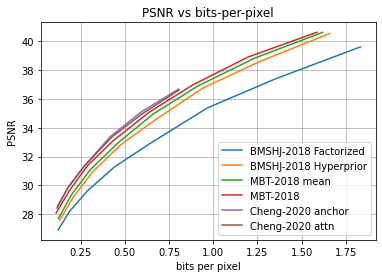

In [147]:
plot_rd_curve(curve_dict, "PSNR")

<AxesSubplot:title={'center':'MeanSquaredError vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='MeanSquaredError'>

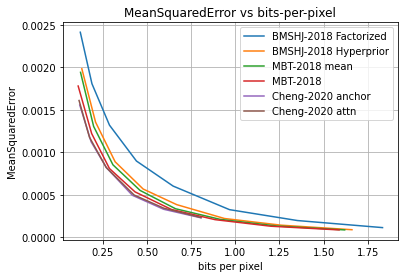

In [148]:
plot_rd_curve(curve_dict, "MeanSquaredError")

<AxesSubplot:title={'center':'MultiscaleStructuralSimilarity vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='MS-SSIM (dB)'>

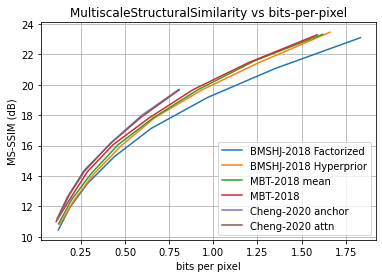

In [149]:
# Plotting MS-SSIM in dB as is done in the Scale Hyperprior paper.
plot_rd_curve(
    curve_dict, 
    "MultiscaleStructuralSimilarity", 
    y_transform = lambda d: -10*math.log10(1 - d), 
    y_label = "MS-SSIM (dB)"
)

# Conclusion

Check out the [torchmetrics documentation](https://torchmetrics.readthedocs.io/en/latest/) for more details on metric features like syncing state across processes and compatability with PyTorch Lightning.

In [152]:
file1 = open("to_save.txt", "w") 
file1.write(str(curve_dict))
file1.close()


In [153]:
 torch.save(curve_dict['Cheng-2020 anchor'],"./shp_curve.pt")

In [156]:
 torch.save(curve_dict['JPEG'],"./jpeg.pt")